In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import pandas as pd
import os
import time
import itertools
import lightkurve
from cesium import featurize
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

## Experimenting with Classifiers on Sector 14 EB Data
In this notebook I will try out a few different classifiers on the sector 14 EB data that I first fit (with a support vector classifier) in the "Sector 14 Kepler EBs Lightcurve Loading and Featurization.ipynb" notebook. I'm thinking of trying a LinearSVC (which I already did, but I'll reproduce it here for organization), a regular SVC/NuSVC (one or both), a k-nearest neighbors classifier, a random forest classifier, and any other ensemble methods that are present if there's time.

I also want to do a grid search of hyperparameters on at least one of these classifiers - I'll have to figure out which scikit-learn function takes care of that, and also don't forget to incorporate cross-validation when I do.

### Load in Data

In [3]:
final_input_df_path = '~/berkeley-seti/sector_14_ebs_nonebs_final_input_df.csv'
final_input_df = pd.read_csv(final_input_df_path,index_col=False)

In [4]:
fset_path = '~/berkeley-seti/sector_14_ebs_nonebs_features.csv'
fset = pd.read_csv(fset_path,index_col=False)

In [5]:
final_input_df

,filename,RA,dec,TIC ID,sector,camera,CCD,mag,label
0,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,299.426873,46.700156,268934915,14,2,4,12.8903,EB
1,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,301.506542,31.797206,90003106,14,1,1,14.9186,Non-EB
2,tesslcs_sector_14_104/tesslcs_tmag_13_14/tessl...,296.658850,42.369743,272709670,14,2,4,13.6568,EB
3,tesslcs_sector_14_104/tesslcs_tmag_13_14/tessl...,307.230318,28.332637,436364347,14,1,4,13.1475,Non-EB
4,tesslcs_sector_14_104/tesslcs_tmag_11_12/tessl...,291.003492,38.526853,122684183,14,1,2,11.8381,EB
...,...,...,...,...,...,...,...,...,...
4167,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,299.301885,20.839294,263369443,14,1,3,14.4938,Non-EB
4168,tesslcs_sector_14_104/tesslcs_tmag_13_14/tessl...,296.887867,26.042990,452218321,14,1,3,13.1081,Non-EB
4169,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,288.327181,46.471706,158730053,14,2,3,12.2458,EB
4170,tesslcs_sector_14_104/tesslcs_tmag_11_12/tessl...,291.018796,38.569840,122684284,14,1,2,11.6844,EB


In [6]:
fset

,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,percent_beyond_1_std,period_fast,skew,std,...,freq2_amplitude2,freq3_amplitude1,freq3_amplitude2,freq_model_max_delta_mags,freq_signif_ratio_21,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,p2p_ssqr_diff_over_var
0,0.147477,0.027686,0.061134,0.139866,0.380408,0.762182,0.157017,0.943707,-1.800833,0.074742,...,0.000315,0.006720,0.000626,2.227777e-01,0.557247,0.492367,0.000189,0.000863,-0.000096,0.133006
1,0.271232,0.125270,0.229506,0.360154,0.505942,0.741434,0.304260,7.030059,-1.219033,0.033004,...,0.001220,0.004076,0.000401,2.738906e-10,0.702989,0.471658,0.000332,0.000504,-0.000008,0.724451
2,0.019973,0.155429,0.270179,0.396614,0.549602,0.761682,0.315015,7.391204,-0.090439,0.006253,...,0.000142,0.001819,0.000557,3.092731e-03,0.524408,0.578947,0.000018,0.000152,0.000009,0.305386
3,0.647317,0.096669,0.167243,0.266520,0.378052,0.601497,0.143147,3.193524,-6.803797,0.072301,...,0.001266,0.004495,0.000310,3.092526e-11,0.878997,0.637711,0.000599,0.001078,-0.000168,0.507704
4,0.097432,0.172465,0.307842,0.448582,0.600992,0.779893,0.327586,0.734223,-4.038254,0.018738,...,0.000344,0.002454,0.000244,1.485219e-02,0.472128,0.332959,0.000066,-0.000162,-0.000037,0.394442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,0.370781,0.113816,0.214648,0.341702,0.491092,0.704121,0.044625,8.080899,-7.670332,0.067641,...,0.000124,0.001327,0.000104,3.042112e-11,0.809644,0.720744,0.000456,-0.000074,-0.000046,0.311539
4168,0.983793,0.047981,0.085120,0.135523,0.208295,0.328064,0.064748,2.854812,3.742587,0.092275,...,0.000220,0.003088,0.000159,2.360124e-11,0.889411,0.862026,0.002074,0.000040,-0.000117,1.019358
4169,0.008264,0.176532,0.312285,0.450796,0.616435,0.820316,0.339549,0.251610,-0.112105,0.002560,...,0.000269,0.000452,0.000227,2.982201e-11,1.070320,0.604045,0.000003,0.000008,0.000027,0.361981
4170,0.112794,0.083686,0.149294,0.235500,0.333543,0.529265,0.084178,14.587795,-7.320314,0.020051,...,0.000106,0.000849,0.000071,2.772533e-11,0.846970,0.861490,0.000064,-0.000274,-0.000010,0.416888


Note here that since I removed the line of 0's from the fset csv file, the dataframe no longer has the "channel" row, so the indexing is different - don't have to do fset['amplitude'][0][0] anymore to get the first amplitude entry - now it's just fset['amplitude'][0].

In [7]:
fset['amplitude'][0]

0.1474766244856866

### LinearSVC (reproduced from previous notebook)

In [332]:
# Update 7/26: Optional bypass of train/test split - instead read in the saved ones from 7-26-21
X_train = pd.read_csv('X_train_7-26-21.csv',index_col=0)
y_train = pd.read_csv('y_train_7-26-21.csv',index_col=0)
X_test = pd.read_csv('X_test_7-26-21.csv',index_col=0)
y_test = pd.read_csv('y_test_7-26-21.csv',index_col=0)

In [7]:
# Train/test split - note that which data goes into train and which goes into test will be different this time
# around then when I first did it in the other notebook because I didn't specify a particular random seed to use
# (see parameters of the function)
train, test = train_test_split(np.arange(len(final_input_df['label'])),train_size=0.5)

In [8]:
# Get X and y for both training and testing data
X_train = fset.iloc[train]
y_train = final_input_df['label'].iloc[train]
X_test = fset.iloc[test]
y_test = final_input_df['label'].iloc[test]

In [65]:
# Update 7/26: Save these so I don't have to worry about continually generating new train/test splits that are
# different from the old ones
X_train.to_csv('X_train_7-26-21.csv')
y_train.to_csv('y_train_7-26-21.csv')
X_test.to_csv('X_test_7-26-21.csv')
y_test.to_csv('y_test_7-26-21.csv')

In [9]:
# Make a pipeline that includes both a StandardScaler and the classifier itself
svc = make_pipeline(StandardScaler(),svm.LinearSVC(dual=False))

In [10]:
# Train the model - finally!
svc.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=False))])

In [11]:
# Test
y_pred = svc.predict(X_test)

In [12]:
# Get accuracy score and precision score
print(accuracy_score(y_test,y_pred)) # Fraction of classifications that were correct
print(precision_score(y_test,y_pred,pos_label='EB')) # Fraction of positive (EB) classifications that were correct
# To be more specific, precision_score returns the ratio tp/(tp+fp), where tp = true positive, fp = false pos.
# and a positive is defined as an "EB" classification

0.761744966442953
0.7955209347614411


In [13]:
print(confusion_matrix(y_test,y_pred))

[[817 287]
 [210 772]]


Thinking about it now, I think it might make the most sense to actually figure out the grid search of hyperparameters now - that way depending on how complicated/involved it is, I might be able to apply it to the other classifiers I try out too. So I'm checking out this link: https://scikit-learn.org/stable/modules/grid_search.html#grid-search. 

What I basically need to do is do a k-fold cross-validation (CV) on my training set, and use that to tune the hyperparameters for a given estimator (in this case, my LinearSVC). Then after I get the optimal hyperparameters, I can test the model on the test set for those hyperparameters. I'm not yet sure how to implement this in scikit-learn, but it could be something like a make_pipeline(StandardScaler(),grid_search,svm.LinearSVC) - although you wouldn't want to do the grid search on the test data (at least, I don't think), so maybe you'd have to have 2 different pipelines - one with the grid search, one without? I'm thinking there's probably an easier way - let me keep reading.

Apparently there's some kind of _score_ method intrinsic to each estimator, and when you do the CV, it evaluates the performance of each set of hyperparameters with a cross_val_score, which is a method you can call like so:

In [ ]:
# from sklearn.model_selection import cross_val_score
# clf = svm.SVC(kernel='linear',C=1,random_state=42)
# scores = cross_val_score(clf,X,y,cv=5) # 5-fold CV

You can then get the mean and standard deviation of the scores with scores.mean() and scores.std(). By default, the scores are the _score_ methods of the estimator, but you can change these to other scores with the _scoring_ parameter of cross_val_score. "accuracy" and "precision" are two examples of these scores (and ones I've already used), along with many others which can be found here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter. 

In [14]:
# Test to make sure that the "score" method of LinearSVC is the same accuracy score as metrics.accuracy_score
svc[1].score(X_test,y_test)

0.6025886864813039

Hmm - not sure what's going on here. Where is this 0.5 coming from and why is it so different from accuracy_score(y_test,y_pred)? Could it be due to svc being a pipeline and maybe the actual LinearSVC element of the pipeline doesn’t save its training? Maybe it’s just randomly predicting each time and that’s why it’s spitting out 0.5.

In [15]:
# Oh wait, let me try actually doing the score function of the pipeline
svc.score(X_test,y_test)

0.761744966442953

Yep, that's exactly what the issue was. Cool, so for a LinearSVC at least, the built-in score() method is the same as sklearn.metrics.accuracy_score.

OK, it seems (based on the "Data transformation with held out data" box) like you can actually feed the entire pipeline into the CV, like so:

In [ ]:
# clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
# cross_val_score(clf, X, y, cv=cv)

The cross_validate function also exists and is different from cross_val_score in that it allows you to use multiple scores at a time, and it also returns the time elapsed to fit the training data and to score it (scoring it on the one "fold" that has been withheld -- recall this is different from the actual "test" data used at the very end).

StratifiedKFold CV is a KFold CV that makes sure each fold has approximately the same fraction of each class of training data as the overall training set does. Sounds like it could be useful - I'm not sure how important that is to get even class representation.

From scikit-learn User Guide section 3.1.4: "Cross validation iterators can also be used to directly perform model selection using Grid Search for the optimal hyperparameters of a model." That sounds like exactly what I want - read more in section 3.2. 

A grid search over hyperparameters consists of 1) an estimator, 2) a parameter space, 3) a method for searching or sampling candidates, 4) a cross-validation scheme, and 5) a score function.

There are two generic methods for searching through parameter space in scikit-learn: GridSearchCV, which exhaustively considers all parameter combinations (i.e., all points in the grid), and RandomizedSearchCV, which samples a given number of candidates from a parameter space with specified distribution. Their counterparts HalvingGridSearchCV and HalvingRandomSearchCV can be much faster. These are still experimental, however, and if you want to enable them you must do so explicitly with "from sklearn.experimental import enable_halving_search_cv."

With GridSearchCV, all possibilities in the grid are considered, and the best combination of parameter values is retained. With RandomizedSearchCV, we randomly sample parameter space. It's important when using RandomizedSearchCV to specify a continuous distribution for your hyperparameter space (e.g., with scipy.stats expon(), gamma(), uniform(), or randint() functions). Having a continuous distribution ensures that when you increase _n_iter_, the number of samples made, you get a finer search.

I think the halving search methods could be useful, but for now I'm going to focus on the regular ones since I just want to get this up and running. 

You can do multimetric scoring with your CV. You can also use GridSearchCV or RandomizedSearchCV to search over a pipeline or other nested estimator. Syntax goes like \<estimator>\_\_\<parameter>; see details at https://scikit-learn.org/stable/modules/grid_search.html#composite-estimators-and-parameter-spaces. So that's good to know - you pass the pipeline in as a parameter to the grid search, not the grid search as a parameter to the pipeline. If any set of parameters in the search results in a failure to fit the data, by default this will cause the entire search to fail, but you can make it robust to failure (i.e., make this not happen) by specifying error_score=0 (setting the score for that fold to 0).

In [9]:
from sklearn.model_selection import GridSearchCV

First let me figure out - what hyperparameters are even available to tune in a LinearSVC? The parameters for the class include _tol_ (tolerance), _C_ (regularization parameter), and that appears to be everything worth tweaking to me. So let's make a grid search!

In [17]:
param_grid = {'linearsvc__tol':[1e-6,1e-5,5e-5,1e-4,5e-4,1e-3,1e-2],'linearsvc__C':[0.01,0.1,1,10,100,1000]}

In [18]:
# Make a pipeline that includes both a StandardScaler and the classifier itself
svc = make_pipeline(StandardScaler(),svm.LinearSVC(dual=False))

In [ ]:
# cv=None --> standard 5-fold CV
# I'm a little concerned about specifying refit='accuracy' here because that's saying that I'll pick the best
# set of hyperparameters to be whichever one maximizes accuracy, which could maybe be biased somehow, especially
# if the data's unbalanced (although this data isn't too out of balance with 2000 non-EBs and 2172 EBs). Anyway
# I'll have to keep overfitting in mind
grid = GridSearchCV(svc,param_grid,scoring=['accuracy','precision'],refit='accuracy',verbose=1,error_score=0)

In [ ]:
# Fit this grid model
grid.fit(X_train,y_train,linearsvc__pos_label='EB')

I'm having issues actually figuring out the place to specify the pos_label criterion for the "precision" scoring metric - I can't figure out where it's supposed to go, but when I run it without it, of course it gives me an error saying that it's trying to score for precision but it doesn't know whether 'EB' or 'Non-EB' should be considered positive. For now I'm going to move on, but I need to figure out how to get this working. But for now I'll just do a single metric: "accuracy". 

Update 7/20: I figured out how to do the above and specify pos_label - you have to use make_scorer (which is where you can configure pos_label etc.) to make a scorer object, and then pass _that_ in to GridSearchCV()'s "scoring" parameter. See https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions for an example.

In [19]:
grid = GridSearchCV(svc,param_grid,scoring='accuracy',verbose=1,error_score=0)

In [20]:
# Fit this grid model
grid.fit(X_train,y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(error_score=0,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc', LinearSVC(dual=False))]),
             param_grid={'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'linearsvc__tol': [1e-06, 1e-05, 5e-05, 0.0001, 0.0005,
                                            0.001, 0.01]},
             scoring='accuracy', verbose=1)

In [21]:
grid.cv_results_ # This dict can be displayed as a Pandas dataframe

{'mean_fit_time': array([0.0168952 , 0.015556  , 0.01400023, 0.01407657, 0.0122716 ,
        0.01228619, 0.01098719, 0.02315965, 0.02081223, 0.02061257,
        0.01946702, 0.01654973, 0.01654053, 0.01425529, 0.03362985,
        0.03066473, 0.02937307, 0.02812157, 0.02659101, 0.02564669,
        0.01798568, 0.03356109, 0.03023949, 0.02923717, 0.02842531,
        0.02524652, 0.02526817, 0.01786013, 0.03605242, 0.03266206,
        0.03005095, 0.02877955, 0.02681823, 0.02596684, 0.01925316,
        0.03503766, 0.03214674, 0.03051476, 0.03017654, 0.0279624 ,
        0.02629848, 0.01835036]),
 'std_fit_time': array([0.00024305, 0.00031774, 0.00034566, 0.00041653, 0.0002414 ,
        0.00027991, 0.00015116, 0.00077881, 0.00134573, 0.00170264,
        0.00035817, 0.00024477, 0.00019723, 0.00046254, 0.00702541,
        0.00665358, 0.0061708 , 0.00592308, 0.00623835, 0.00676662,
        0.00208948, 0.00423899, 0.00540324, 0.00480939, 0.00554677,
        0.00521786, 0.00583062, 0.00236958, 0.006

In [22]:
cv_results_df = pd.DataFrame(grid.cv_results_)

In [23]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,param_linearsvc__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016895,0.000243,0.002719,0.000041,0.01,0.000001,"{'linearsvc__C': 0.01, 'linearsvc__tol': 1e-06}",0.744019,0.733813,0.729017,0.760192,0.705036,0.734415,0.018162,36
1,0.015556,0.000318,0.002858,0.000232,0.01,0.00001,"{'linearsvc__C': 0.01, 'linearsvc__tol': 1e-05}",0.744019,0.733813,0.729017,0.760192,0.705036,0.734415,0.018162,36
2,0.014000,0.000346,0.002649,0.000092,0.01,0.00005,"{'linearsvc__C': 0.01, 'linearsvc__tol': 5e-05}",0.744019,0.733813,0.729017,0.760192,0.705036,0.734415,0.018162,36
3,0.014077,0.000417,0.002737,0.000092,0.01,0.0001,"{'linearsvc__C': 0.01, 'linearsvc__tol': 0.0001}",0.744019,0.733813,0.729017,0.760192,0.705036,0.734415,0.018162,36
4,0.012272,0.000241,0.002590,0.000063,0.01,0.0005,"{'linearsvc__C': 0.01, 'linearsvc__tol': 0.0005}",0.744019,0.733813,0.729017,0.760192,0.705036,0.734415,0.018162,36
5,0.012286,0.000280,0.002598,0.000103,0.01,0.001,"{'linearsvc__C': 0.01, 'linearsvc__tol': 0.001}",0.744019,0.733813,0.729017,0.760192,0.705036,0.734415,0.018162,36
6,0.010987,0.000151,0.002587,0.000055,0.01,0.01,"{'linearsvc__C': 0.01, 'linearsvc__tol': 0.01}",0.744019,0.736211,0.726619,0.760192,0.705036,0.734415,0.018351,36
7,0.023160,0.000779,0.002816,0.000041,0.1,0.000001,"{'linearsvc__C': 0.1, 'linearsvc__tol': 1e-06}",0.753589,0.726619,0.736211,0.755396,0.724221,0.739207,0.013122,15
8,0.020812,0.001346,0.002799,0.000099,0.1,0.00001,"{'linearsvc__C': 0.1, 'linearsvc__tol': 1e-05}",0.753589,0.726619,0.736211,0.755396,0.724221,0.739207,0.013122,15
9,0.020613,0.001703,0.002776,0.000055,0.1,0.00005,"{'linearsvc__C': 0.1, 'linearsvc__tol': 5e-05}",0.753589,0.726619,0.736211,0.755396,0.724221,0.739207,0.013122,15


In [24]:
# Test
y_pred = grid.predict(X_test)

In [25]:
# Get accuracy score and precision score
print(accuracy_score(y_test,y_pred)) # Fraction of classifications that were correct
print(precision_score(y_test,y_pred,pos_label='EB')) # Fraction of positive (EB) classifications that were correct

0.761744966442953
0.7955209347614411


Well, the results in terms of accuracy and precision are not too stunning, but it is exciting that I got the grid search working! Things are going up. I'll come back tomorrow morning.

### Weights & Biases Testing
I just worked through the "Intro to Weights & Biases" notebook on Colab, so let me see if I can actually get it running here. I installed W&B with "pip install wandb -qqq" so let me see how this goes.

In [10]:
import wandb

In [11]:
wandb.login()

wandb: Currently logged in as: parsellsx (use `wandb login --relogin` to force relogin)


True

It looks to me like every run in Weights & Biases is basically an attempt at training/testing a model, with different settings (could be a different classifier, different hyperparameter values, etc.). I'm not sure this is true, but that's my understanding so far. And it seems like a lot of those different parameters for a given run can get saved and then you can group runs by different parameters in the W&B web interface to see which produced the best results and which are most and least influential. 

It sounds like a lot of what you would want to save gets saved either with wandb.config, an object that keeps track of "your training configuration: hyperparameters, input settings like dataset name or model type, and any other independent variables for your experiments," or with wandb.log, a function that keeps track of "output metrics or dependent variables (like loss and accuracy)". 

You can start a project with wandb.init() - let me try this below. When doing this you can supply the config dictionary as a parameter to init(), but you don't have to - you can also just do, for example, wandb.config.epochs = 4 in a separate line below. And even if you initialize config in init(), you can edit it later on like a dictionary.

The Parallel Coordinates chart lets you make comparisons between Runs. It represents each run as a curvy line and the line passes through the config values or logged metrics that you choose to display for that run. This lets you glance at the chart and see which hyperparameter configurations were most and least successful.

wandb.log() lets you supply a dictionary of metrics and their values to a given run. At least, I think it's for a given run. Apparently there's also some kind of "step" that gets incremented each time you log, allowing you to view metrics over time. The "Log Data & Media with wandb.log" page also has a lot of examples on logging media like audio, video, images, etc., but I don't understand the utility of that right now. Update: I think actually it's useful for logging plots and anything you make from your data - store it with the run that it came from in W&B.

Sources consulted: https://docs.wandb.ai/quickstart, https://docs.wandb.ai/ref/python/init, https://docs.wandb.ai/guides/track/config, https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Configs_in_W%26B.ipynb, https://docs.wandb.ai/guides/track/log

In [ ]:
wandb.init(project='tess',group='svc2')

It sounds like I'll still be mostly using sklearn modules and functions to do what I need to do, but I can log it with W&B by supplying the inputs and outputs of everything to W&B. According to https://docs.wandb.ai/guides/integrations/scikit, there is some kind of W&B wrapper on sklearn functions like so: wandb.sklearn.plot_confusion_matrix(y_true,y_pred,labels)

Possibly helpful Colab notebook on hyperparameter sweeps with W&B in TensorFlow: https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Hyperparameter%20Sweeps%20with%20TF%202.0%20%26%20W%26B/Hyperparameter%20Sweeps%20(part%20I)%20with%20TF%202.0%20and%20W%26B.ipynb.

And a probably better one with PyTorch (from Daniel): https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb.

The code on the bottom of this page (https://wandb.ai/site/articles/p-picking-a-machine-learning-model) is actually pretty helpful in showing you how to use W&B in conjunction with sklearn. 

Apparently when hyperparameter sweeping with W&B, there are two components working together: a controller on the central sweep server, which picks out new hyperparameter combinations to try, and agents that query the server for hyperparameters, use them to run model training, and report the results back to the controller. Works great for parallelization.

Good links for doing sweeping: https://docs.wandb.ai/guides/sweeps/python-api and https://docs.wandb.ai/guides/sweeps/configuration.

After we "initialize the sweep" with a sweep_config (make a dictionary and pass it in to wandb.sweep()), we need to define an agent with wandb.agent(), which accepts the sweep object we just made, as well as a function to run training based on the hyperparameters in the sweep object. What I don't understand (yet) is how we take the parameters we put in the sweep object and translate them into actual sklearn commands to get a model going.

Let me try to actually get some stuff going now.

#### SVC
Since there are 3 steps to getting hyperparameter sweeps going with W&B and one of them involves writing a _train_ function to define the model architecture and train it, let me try to do that now:

In [ ]:
# This will contain the hyperparameters I want to optimize, along with a grid of the values I want to try. These
# names are coming from the sklearn.svm.SVC documentation
# Not sure how to handle this in the case where certain hyperparameters aren't compatible with certain others - 
# e.g., in the sklearn docs they suggest passing in a list of dicts to GridSearchCV() so you only search the 
# param combinations that are compatible, but here I don't know if I can do that in the W&B framework. Might just
# pass in ones that I know will raise errors and keep the error_score parameter of GridSearchCV() at the default
# np.nan to see which ones raised errors and were incompatible

In [ ]:
def svctrain(config=None):
    # Couple of key insights I got from Daniel: 1) Include the "with wandb.init(config=config)" etc. lines below -
    # I was going to just rely on the wandb.init that I had higher up in this notebook; that doesn't work because
    # I need a new run (and therefore a new wandb.init()) for every set of hyperparameters that I want to try. 
    # 2) You DON'T need the actual GridSearchCV() from sklearn in this function! The W&B sweep takes care of that
    # automatically
    with wandb.init(config=config):
        config = wandb.config
        # Make a pipeline that includes both a StandardScaler and the classifier itself
        # I was confused at first when W&B offered the ability to specify hyperparameters in your sweep_config 
        # that you weren't actually going to vary (just give one value for a hyperparameter) - now I just realized
        # two reasons why you might do that. 1) You want to use a value that's not the default for that classifier
        # in sklearn (or Keras or whatever). 2) You could maybe even specify every single hyperparameter given in
        # the sklearn docs, in order, and then maybe rather than specifying C=config.C,kernel=config.kernel, etc.
        # in the line below, you could just do something like svm.SVC(config*)!
        svc = make_pipeline(StandardScaler(),svm.SVC(C=config.C,kernel=config.kernel,gamma=config.gamma,tol=config.tol))
        svc.fit(X_train,y_train)
        y_pred = svc.predict(X_test)
        wandb.log({'accuracy': accuracy_score(y_test,y_pred),
                  'precision': precision_score(y_test,y_pred,pos_label='EB')})

In [ ]:
parameters_dict = {
    'C': {
        'values': [0.001,0.009,0.01,0.09,1,5,10,25] # From https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
    },
    'kernel': {
        'values': ['poly','rbf','sigmoid']
    },
    'gamma': {
        'values': ['scale','auto']
    },
    'tol': {
        'values': [1e-4,1e-3,1e-2]
    }
}
metric = {'name': 'accuracy'}
# Apparently when using a sweep in W&B, any config that you passed to wandb.init() is treated as a default, and it
# can be overwritten by whatever comes next in the sweep config
sweep_config = {
    'name': 'test-sweep-1',
    'method': 'grid',
    'metric': metric,
    'parameters': parameters_dict,
    'project': 'tess', # Might not be necessary
    'description': 'First ever test sweep. Varying C, kernel, gamma, and tol in an sklearn.svm.SVC.'
}
sweep_id = wandb.sweep(sweep_config,project='tess')

In [ ]:
wandb.agent(sweep_id,function=svctrain)

With help from Daniel in our meeting (7/20, 2 pm), I was able to get the first W&B sweep going! As the output says, the sweep page is at https://wandb.ai/parsellsx/tess/sweeps/eppfznlq. 

Now I'm going to try a second sweep, this time fixing an issue. The first sweep, when you look at the parallel coordinates plot that shows up on the web interface, it seems to show _tol_ as the metric to optimize, when really, it should be accuracy. So I'm going to try to fix that so that I can get a nice looking plot. I'm also going to try logging some new metrics that I haven't used before, besides just accuracy and precision.

In [23]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

In [ ]:
def svctrain(config=None):
    with wandb.init(config=config):
        config = wandb.config
        # Make a pipeline that includes both a StandardScaler and the classifier itself
        svc = make_pipeline(StandardScaler(),svm.SVC(C=config.C,kernel=config.kernel,gamma=config.gamma,tol=config.tol))
        svc.fit(X_train,y_train)
        y_pred = svc.predict(X_test)
        wandb.log({'accuracy': accuracy_score(y_test,y_pred),
                  'precision': precision_score(y_test,y_pred,pos_label='EB'),
                  'confusion matrix': confusion_matrix(y_test,y_pred),
                  'recall': recall_score(y_test,y_pred,pos_label='EB'),
                  'roc curve': roc_curve(y_test,svc.decision_function(y_train),pos_label='EB')})

In [ ]:
# 2nd try
parameters_dict = { # Same as 1st sweep
    'C': {
        'values': [0.001,0.009,0.01,0.09,1,5,10,25] # From https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
    },
    'kernel': {
        'values': ['poly','rbf','sigmoid']
    },
    'gamma': {
        'values': ['scale','auto']
    },
    'tol': {
        'values': [1e-4,1e-3,1e-2]
    }
}
metric = {'name': 'accuracy',
         'goal': 'maximize'}
# Apparently when using a sweep in W&B, any config that you passed to wandb.init() is treated as a default, and it
# can be overwritten by whatever comes next in the sweep config
sweep_config = {
    'name': 'test-sweep-2',
    'method': 'grid',
    'metric': metric,
    'parameters': parameters_dict,
    'project': 'tess', # Might not be necessary
    'description': 'Second ever test sweep. Still using sklearn.svm.SVC. Fixing issue with parallel coords. plot.'
}
sweep_id = wandb.sweep(sweep_config,project='tess')

In [ ]:
wandb.agent(sweep_id,function=svctrain)

### Update 7/26
Trying basically a "starting over" with Weights & Biases - I'm going to make a "group" of runs called "svc2" that I will use to organize my runs and sweeps better. I'll have to redefine my train function below and also the parameters_dict. Let's see how this goes.

In [29]:
def svctrain(config=None):
    with wandb.init(project='tess',group='svc2',config=config):
        config = wandb.config
        # Make a pipeline that includes both a StandardScaler and the classifier itself
        svc = make_pipeline(StandardScaler(),svm.SVC(C=config.C,kernel=config.kernel,gamma=config.gamma,tol=config.tol))
        svc.fit(X_train,y_train)
        y_pred = svc.predict(X_test)
        wandb.log({'accuracy': accuracy_score(y_test,y_pred),
                  'precision': precision_score(y_test,y_pred,pos_label='EB'),
                  'confusion matrix': confusion_matrix(y_test,y_pred),
                  'recall': recall_score(y_test,y_pred,pos_label='EB')})
#                   'roc curve': roc_curve(y_test,svc.decision_function(y_train),pos_label='EB')

In [30]:
# New try
parameters_dict = { # Same as 1st sweep
    'C': {
        'values': [0.001,0.009,0.01,0.09,1,5,10,25] # From https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
    },
    'kernel': {
        'values': ['poly','rbf','sigmoid']
    },
    'gamma': {
        'values': ['scale','auto']
    },
    'tol': {
        'values': [1e-4,1e-3,1e-2]
    }
}
metric = {'name': 'accuracy',
         'goal': 'maximize'}
# Apparently when using a sweep in W&B, any config that you passed to wandb.init() is treated as a default, and it
# can be overwritten by whatever comes next in the sweep config
sweep_config = {
    'name': 'test-sweep-3',
    'method': 'grid',
    'metric': metric,
    'parameters': parameters_dict,
    'project': 'tess', # Might not be necessary
    'description': 'Third attempt at a sweep with SVC. Grouped runs for 1st time and trying to get par. coo. plot.'
}
sweep_id = wandb.sweep(sweep_config,project='tess')

Create sweep with ID: ch9xdjvq
Sweep URL: https://wandb.ai/parsellsx/tess/sweeps/ch9xdjvq


In [31]:
wandb.agent(sweep_id,function=svctrain,project='tess')

wandb: Agent Starting Run: ef3ouvol with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.53164
precision,0.53051
recall,1.0
_runtime,7
_timestamp,1627327275
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vnznomm7 with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.53164
precision,0.53051
recall,1.0
_runtime,6
_timestamp,1627327285
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rjbuavhy with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.53164
precision,0.53051
recall,1.0
_runtime,6
_timestamp,1627327295
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6cnmslip with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327306
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5wzmzb2u with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327316
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1plkxbz1 with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327326
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gdz4o178 with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327336
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u9l36m6t with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327346
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ikpysyus with config:
wandb: 	C: 0.001
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327356
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: btlprojf with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.53164
precision,0.53051
recall,1.0
_runtime,7
_timestamp,1627327367
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: foa8cwyo with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.53164
precision,0.53051
recall,1.0
_runtime,7
_timestamp,1627327377
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q3dksjse with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.53164
precision,0.53051
recall,1.0
_runtime,6
_timestamp,1627327387
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: iljuqp42 with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327398
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jft2idx6 with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327409
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nfewglg5 with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327419
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8pc93ts3 with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327429
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: labnqknd with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327440
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xmw33x0n with config:
wandb: 	C: 0.001
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.52924
precision,0.52924
recall,1.0
_runtime,7
_timestamp,1627327451
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jv9a4o8b with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.96615
recall,0.28442
_runtime,7
_timestamp,1627327461
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rj1pml1h with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.96615
recall,0.28442
_runtime,6
_timestamp,1627327471
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mbqzhwco with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61553
precision,0.96605
recall,0.28351
_runtime,6
_timestamp,1627327481
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7mipjkse with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.68169
precision,0.82164
recall,0.50906
_runtime,7
_timestamp,1627327492
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: e6l78ldj with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.68169
precision,0.82164
recall,0.50906
_runtime,7
_timestamp,1627327502
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5fp08wq2 with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.68169
precision,0.82164
recall,0.50906
_runtime,7
_timestamp,1627327512
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: t63fnimt with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67546
precision,0.81168
recall,0.50362
_runtime,7
_timestamp,1627327522
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jxprca80 with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67546
precision,0.81168
recall,0.50362
_runtime,7
_timestamp,1627327532
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bxqg9c81 with config:
wandb: 	C: 0.009
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67546
precision,0.81077
recall,0.50453
_runtime,7
_timestamp,1627327543
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: blqnzspd with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.96615
recall,0.28442
_runtime,6
_timestamp,1627327553
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: prdgximd with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.96615
recall,0.28442
_runtime,7
_timestamp,1627327564
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g517j6ki with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61553
precision,0.96605
recall,0.28351
_runtime,7
_timestamp,1627327574
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r5qykftg with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.68169
precision,0.82164
recall,0.50906
_runtime,7
_timestamp,1627327584
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: yywlbcwr with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.68169
precision,0.82164
recall,0.50906
_runtime,7
_timestamp,1627327594
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cvehxox5 with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.68169
precision,0.82164
recall,0.50906
_runtime,7
_timestamp,1627327604
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 07mzs14z with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67546
precision,0.81168
recall,0.50362
_runtime,7
_timestamp,1627327614
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4alhabrq with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67546
precision,0.81168
recall,0.50362
_runtime,7
_timestamp,1627327624
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: krzz0vgy with config:
wandb: 	C: 0.009
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67546
precision,0.81077
recall,0.50453
_runtime,7
_timestamp,1627327634
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xtzga0q1 with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61266
precision,0.96541
recall,0.27808
_runtime,7
_timestamp,1627327644
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rgxiejzf with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61266
precision,0.96541
recall,0.27808
_runtime,6
_timestamp,1627327654
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: tglgq2q9 with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61266
precision,0.96541
recall,0.27808
_runtime,7
_timestamp,1627327665
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rnvype67 with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.83591
recall,0.48913
_runtime,7
_timestamp,1627327675
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u55mhct4 with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.83591
recall,0.48913
_runtime,7
_timestamp,1627327685
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 996rsy8s with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.83591
recall,0.48913
_runtime,7
_timestamp,1627327696
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: p0m17e0a with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67977
precision,0.82733
recall,0.49909
_runtime,7
_timestamp,1627327707
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: i469cxyw with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67977
precision,0.82733
recall,0.49909
_runtime,7
_timestamp,1627327717
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s9cbavub with config:
wandb: 	C: 0.01
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67929
precision,0.82609
recall,0.49909
_runtime,7
_timestamp,1627327728
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: h249sh2w with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61266
precision,0.96541
recall,0.27808
_runtime,7
_timestamp,1627327738
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x5kgig4e with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61266
precision,0.96541
recall,0.27808
_runtime,7
_timestamp,1627327748
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3u9i76k9 with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61266
precision,0.96541
recall,0.27808
_runtime,7
_timestamp,1627327758
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: my3b65yc with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.83591
recall,0.48913
_runtime,7
_timestamp,1627327768
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ih41h3e9 with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.83591
recall,0.48913
_runtime,7
_timestamp,1627327779
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ojjmonn9 with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.83591
recall,0.48913
_runtime,7
_timestamp,1627327789
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9gfmsbi6 with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67977
precision,0.82733
recall,0.49909
_runtime,7
_timestamp,1627327800
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ve6p3u1g with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67977
precision,0.82733
recall,0.49909
_runtime,7
_timestamp,1627327810
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zg956hc4 with config:
wandb: 	C: 0.01
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67929
precision,0.82609
recall,0.49909
_runtime,7
_timestamp,1627327820
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q1pnwcad with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.6395
precision,0.97826
recall,0.32609
_runtime,7
_timestamp,1627327832
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: drs0jdqc with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.6395
precision,0.97826
recall,0.32609
_runtime,7
_timestamp,1627327842
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: l7wnoa3t with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.6395
precision,0.97826
recall,0.32609
_runtime,7
_timestamp,1627327852
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: tbclzbap with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75983
precision,0.84855
recall,0.66486
_runtime,7
_timestamp,1627327862
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: pqvp3gvs with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75983
precision,0.84855
recall,0.66486
_runtime,7
_timestamp,1627327872
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xx3sjcf7 with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75935
precision,0.84838
recall,0.66395
_runtime,7
_timestamp,1627327882
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6ymptxtd with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.72052
precision,0.81807
recall,0.60688
_runtime,7
_timestamp,1627327892
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ah14955i with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.72052
precision,0.81807
recall,0.60688
_runtime,6
_timestamp,1627327902
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7hlcv3m1 with config:
wandb: 	C: 0.09
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.72052
precision,0.81807
recall,0.60688
_runtime,6
_timestamp,1627327912
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: kj5sm48q with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.6395
precision,0.97826
recall,0.32609
_runtime,6
_timestamp,1627327922
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 69412arj with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.6395
precision,0.97826
recall,0.32609
_runtime,6
_timestamp,1627327932
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 58wuz745 with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.6395
precision,0.97826
recall,0.32609
_runtime,7
_timestamp,1627327943
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 74u2dohq with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75983
precision,0.84855
recall,0.66486
_runtime,6
_timestamp,1627327953
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: b9b55j01 with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75983
precision,0.84855
recall,0.66486
_runtime,6
_timestamp,1627327963
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: o4svgb9s with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75935
precision,0.84838
recall,0.66395
_runtime,7
_timestamp,1627327974
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ldjho9cy with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.72052
precision,0.81807
recall,0.60688
_runtime,7
_timestamp,1627327985
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v1awbgb6 with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.72052
precision,0.81807
recall,0.60688
_runtime,6
_timestamp,1627327995
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: snpocbve with config:
wandb: 	C: 0.09
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.72052
precision,0.81807
recall,0.60688
_runtime,6
_timestamp,1627328005
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fx49c8df with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71141
precision,0.95307
recall,0.47826
_runtime,7
_timestamp,1627328016
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1h1egu48 with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71141
precision,0.95307
recall,0.47826
_runtime,7
_timestamp,1627328026
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: puz6wj8b with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71141
precision,0.95307
recall,0.47826
_runtime,7
_timestamp,1627328036
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bgb15kbw with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78907
precision,0.84801
recall,0.73279
_runtime,7
_timestamp,1627328046
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fu66o7sf with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78907
precision,0.84801
recall,0.73279
_runtime,7
_timestamp,1627328056
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qczue6ht with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78859
precision,0.84785
recall,0.73188
_runtime,7
_timestamp,1627328066
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zad2e2g8 with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.70055
recall,0.68659
_runtime,7
_timestamp,1627328076
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 12sa86o4 with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.70055
recall,0.68659
_runtime,7
_timestamp,1627328086
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5ny2kblw with config:
wandb: 	C: 1
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.70055
recall,0.68659
_runtime,6
_timestamp,1627328096
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: htihss5z with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71141
precision,0.95307
recall,0.47826
_runtime,6
_timestamp,1627328106
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r981eqfx with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71141
precision,0.95307
recall,0.47826
_runtime,6
_timestamp,1627328116
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ia1noc5b with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71141
precision,0.95307
recall,0.47826
_runtime,7
_timestamp,1627328127
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: e1z11m6u with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78907
precision,0.84801
recall,0.73279
_runtime,6
_timestamp,1627328137
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ri66530i with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78907
precision,0.84801
recall,0.73279
_runtime,7
_timestamp,1627328148
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: sznux6cu with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78859
precision,0.84785
recall,0.73188
_runtime,7
_timestamp,1627328158
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jswgvlk4 with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.70055
recall,0.68659
_runtime,7
_timestamp,1627328168
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u85t2ied with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.70055
recall,0.68659
_runtime,6
_timestamp,1627328178
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bxz35icm with config:
wandb: 	C: 1
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.67881
precision,0.70055
recall,0.68659
_runtime,6
_timestamp,1627328188
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wh9w4uuq with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.74976
precision,0.89538
recall,0.59692
_runtime,6
_timestamp,1627328198
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6f2l4afe with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.74976
precision,0.89538
recall,0.59692
_runtime,7
_timestamp,1627328209
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: m69my3ih with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75024
precision,0.8966
recall,0.59692
_runtime,7
_timestamp,1627328219
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rfnlc90c with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79338
precision,0.83684
recall,0.75725
_runtime,7
_timestamp,1627328229
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2rjnckhf with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79338
precision,0.83684
recall,0.75725
_runtime,7
_timestamp,1627328239
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qmt47gjq with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79386
precision,0.83768
recall,0.75725
_runtime,6
_timestamp,1627328249
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 12rpijzk with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.6478
recall,0.60145
_runtime,6
_timestamp,1627328259
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: eq4gy8ak with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.6478
recall,0.60145
_runtime,6
_timestamp,1627328269
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: m5488cb1 with config:
wandb: 	C: 5
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.6478
recall,0.60145
_runtime,6
_timestamp,1627328279
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9vzduzt2 with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.74976
precision,0.89538
recall,0.59692
_runtime,6
_timestamp,1627328289
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q6lhxcbu with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.74976
precision,0.89538
recall,0.59692
_runtime,6
_timestamp,1627328299
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3iezzshn with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75024
precision,0.8966
recall,0.59692
_runtime,6
_timestamp,1627328310
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bmkspow2 with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79338
precision,0.83684
recall,0.75725
_runtime,7
_timestamp,1627328321
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7pzxg3uz with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79338
precision,0.83684
recall,0.75725
_runtime,7
_timestamp,1627328331
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gknhkeym with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79386
precision,0.83768
recall,0.75725
_runtime,6
_timestamp,1627328341
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: yvnwgnx7 with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.6478
recall,0.60145
_runtime,6
_timestamp,1627328351
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: kx4nqvas with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.6478
recall,0.60145
_runtime,6
_timestamp,1627328361
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rz2n8s30 with config:
wandb: 	C: 5
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.6478
recall,0.60145
_runtime,7
_timestamp,1627328372
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5jjimqrv with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.88706
recall,0.63315
_runtime,7
_timestamp,1627328382
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ovqo8d0q with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.88706
recall,0.63315
_runtime,6
_timestamp,1627328392
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: c6nuhwkd with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.88706
recall,0.63315
_runtime,6
_timestamp,1627328402
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nbfi67hk with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79099
precision,0.83069
recall,0.75996
_runtime,7
_timestamp,1627328413
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: km5dnq56 with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79099
precision,0.83069
recall,0.75996
_runtime,7
_timestamp,1627328423
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dl5h9dnn with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79003
precision,0.83036
recall,0.75815
_runtime,7
_timestamp,1627328435
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xnf22mhx with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.64723
recall,0.60326
_runtime,7
_timestamp,1627328445
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v6v7juw9 with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.64723
recall,0.60326
_runtime,7
_timestamp,1627328455
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zly2szg4 with config:
wandb: 	C: 10
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.64723
recall,0.60326
_runtime,7
_timestamp,1627328465
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: on2les0t with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.88706
recall,0.63315
_runtime,6
_timestamp,1627328475
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qrv6tb4u with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.88706
recall,0.63315
_runtime,6
_timestamp,1627328485
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: oo22ut9z with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.88706
recall,0.63315
_runtime,6
_timestamp,1627328495
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wfpyrnkt with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79099
precision,0.83069
recall,0.75996
_runtime,7
_timestamp,1627328506
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: aqflaole with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79099
precision,0.83069
recall,0.75996
_runtime,7
_timestamp,1627328516
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: upwc21ir with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.79003
precision,0.83036
recall,0.75815
_runtime,7
_timestamp,1627328526
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 38uu8i7z with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.64723
recall,0.60326
_runtime,6
_timestamp,1627328536
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: sgnraa5e with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.64723
recall,0.60326
_runtime,6
_timestamp,1627328546
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: tu5si4bo with config:
wandb: 	C: 10
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61601
precision,0.64723
recall,0.60326
_runtime,6
_timestamp,1627328556
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6ozogro9 with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.85509
recall,0.70018
_runtime,6
_timestamp,1627328566
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6llk9tdb with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.85509
recall,0.70018
_runtime,6
_timestamp,1627328576
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jyfmb9tz with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.85509
recall,0.70018
_runtime,7
_timestamp,1627328587
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xf1l86ln with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78859
precision,0.81844
recall,0.77174
_runtime,7
_timestamp,1627328598
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nft4bm2g with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78859
precision,0.81844
recall,0.77174
_runtime,7
_timestamp,1627328608
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r9n9chiz with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78955
precision,0.8194
recall,0.77264
_runtime,7
_timestamp,1627328618
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ycnc84g2 with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61026
precision,0.64223
recall,0.59511
_runtime,7
_timestamp,1627328628
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ny7hzqny with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61026
precision,0.64223
recall,0.59511
_runtime,6
_timestamp,1627328638
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: shtfpmu1 with config:
wandb: 	C: 25
wandb: 	gamma: scale
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61026
precision,0.64223
recall,0.59511
_runtime,6
_timestamp,1627328648
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qirn4o9i with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.85509
recall,0.70018
_runtime,7
_timestamp,1627328659
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ojhndso1 with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.85509
recall,0.70018
_runtime,7
_timestamp,1627328670
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: n2ajcc8v with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: poly
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.85509
recall,0.70018
_runtime,6
_timestamp,1627328680
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zf8unejq with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78859
precision,0.81844
recall,0.77174
_runtime,6
_timestamp,1627328690
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4i2urnpn with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78859
precision,0.81844
recall,0.77174
_runtime,7
_timestamp,1627328701
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1zhq7q0i with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: rbf
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.78955
precision,0.8194
recall,0.77264
_runtime,7
_timestamp,1627328711
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qreeyu5y with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61026
precision,0.64223
recall,0.59511
_runtime,7
_timestamp,1627328721
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 88paxg3n with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61026
precision,0.64223
recall,0.59511
_runtime,7
_timestamp,1627328731
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9xme8atc with config:
wandb: 	C: 25
wandb: 	gamma: auto
wandb: 	kernel: sigmoid
wandb: 	tol: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.61026
precision,0.64223
recall,0.59511
_runtime,6
_timestamp,1627328741
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Let's go! I got my SVC trained properly with test-sweep-3 in the TESS project - access it here (https://wandb.ai/parsellsx/tess/sweeps/ch9xdjvq) and then make sure you toggle off the "Grid" button (middle of the 3 buttons at the top of the list of runs on the left) so that you can see all the runs individually in the parallel coordinates plot. 

What's next? Well, I want to try other classifier types - let me next try a RandomForestClassifier(). But I also want to filter out some of the data per my discussion with Daniel last Tuesday 7/20 - remove EBs with periods longer than 15 days or so - see daily notes. For now though I'll just do the above with the data unchanged with a random forest classifier.

#### Random Forest Classifier

Some stuff I'm reading about decision trees (https://scikit-learn.org/stable/modules/tree.html): 

It sounds like you might not need to normalize the data (i.e., use a StandardScaler) with decision trees (DTs). Here's a con, though: DTs can create overly complex trees that don't generalize well (overfitting) - to stop this, you need to either prune the tree, set a minimum number of samples required at a leaf node (I think this means min. number of pts. satisfying a given set of conditions in the tree), or set a maximum depth of tree (max number of decision branching points that can be made for a given sample). 

Another con: decision tree learners create biased trees if the data is dominated by certain classes, and for this reason they recommend balancing the dataset before fitting a DT. Although, I guess my dataset is decently well balanced since I have 2172 EBs compared to 2000 non-EBs.

There is a sklearn.tree.plot_tree function that, for a single decision tree classifier, will actually print out the full decision-making structure of the tree as a graphic once you fit it on some data. Pretty cool! Not sure yet if there's a corresponding option for the RandomForestClassifier. 

In random forests, each tree in the ensemble is built from a sample, drawn _with replacement_, from the training set. Also, when building the actual decision nodes of the tree, the best split is decided either from all input features (what you would expect) _or_ from a random subset of features of size max_features (see parameters). The reason for these two "sources of randomness" is to reduce the overall variance of the forest classifier, since individual DTs typically have high variance and tend to overfit. sklearn implements random forest classifiers by averaging the probabilistic predictions of all the DTs in the forest (as opposed to just letting each DT vote for a single class).

Main hyperparameters to adjust with a RandomForestClassifier: n_estimators (number of trees in the forest) and max_features (size of the random subsets of features to consider when splitting a node). More trees is better, but it comes at a computational cost, and there is some critical number of trees beyond which improvement will be very limited. An empirical good default value is max_features='sqrt' for classification problems, meaning we use sqrt(n_features) in our randomly selected feature subsets. Apparently max_depth=None with min_samples_split=2 often yields good results, but the results are usually not _optimal_ and might consume a lot of RAM. "The best parameter values should always be cross-validated."

The n_jobs parameter gives the number of cores of the machine to split up the building of trees on. n_jobs=-1 means to use all the cores available. Speedup is not linear but can still be pretty good when you have either a lot of trees or large datasets. 

Depth of a given feature (how low in the tree do nodes based on that feature appear) is a good proxy for the general importance of that feature to the classification.

In [221]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
from sklearn.metrics import plot_roc_curve

In [20]:
def foresttrain(config=None):
    with wandb.init(project='tess',group='forest1',config=config):
        config = wandb.config
        # Not sure if the StandardScaler is necessary with a decision tree/random forest...
        clf = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=config.n_estimators,criterion=config.criterion,max_depth=config.max_depth,min_samples_split=config.min_samples_split,max_features=config.max_features,n_jobs=config.n_jobs,random_state=config.random_state))
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        wandb.log({'accuracy': accuracy_score(y_test,y_pred),
                  'precision': precision_score(y_test,y_pred,pos_label='EB'),
                  'confusion matrix': confusion_matrix(y_test,y_pred),
                  'recall': recall_score(y_test,y_pred,pos_label='EB')})
#                   'roc_plot': plot_roc_curve(clf,X_test,y_test,pos_label='EB')}) # Trying this out
#                   'roc curve': roc_curve(y_test,svc.decision_function(y_train),pos_label='EB')

In [21]:
# Random forest
parameters_dict = {
    # Other parameters I could try that I haven't included here: 
    'n_estimators': {
        'values': [1,10,100,500,1000]
    },
    'criterion': {
        'values': ['gini','entropy']
    },
    'max_depth': {
        'values': [3,5,10,50,None]
    },
    'min_samples_split': {
        'values': [2,5,10,50]
    },
    'max_features': { # Could try different integer values in the future
        'values': ['sqrt',None]
    },
    'n_jobs': {
        'value': -1 # Use all cores available in parallel
    },
    'random_state': { # Run with the same value again to get consistent results (though there may be slight var.)
        'value': 42
    }
}
metric = {'name': 'accuracy',
         'goal': 'maximize'}
sweep_config = {
    'name': 'forest-sweep-1',
    'method': 'grid',
    'metric': metric,
    'parameters': parameters_dict,
    'project': 'tess', # Might not be necessary
    'description': 'First Random Forest sweep'
}
sweep_id = wandb.sweep(sweep_config,project='tess')

Create sweep with ID: hi03tv69
Sweep URL: https://wandb.ai/parsellsx/tess/sweeps/hi03tv69


In [22]:
wandb.agent(sweep_id,function=foresttrain,project='tess')

wandb: Agent Starting Run: idi1vos3 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66779
precision,0.85128
recall,0.45109
_runtime,6
_timestamp,1627346854
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8i4js41r with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.74545
precision,0.80446
recall,0.68569
_runtime,6
_timestamp,1627346864
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fp98vn44 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77133
precision,0.83458
recall,0.70833
_runtime,7
_timestamp,1627346875
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: axl6fh36 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76942
precision,0.82686
recall,0.71377
_runtime,9
_timestamp,1627346887
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5tlkypw4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76702
precision,0.82595
recall,0.70924
_runtime,12
_timestamp,1627346902
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qxlgpfdx with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66779
precision,0.85128
recall,0.45109
_runtime,6
_timestamp,1627346912
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: t6ricdja with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.74545
precision,0.80446
recall,0.68569
_runtime,6
_timestamp,1627346922
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: axf6ca8e with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77133
precision,0.83458
recall,0.70833
_runtime,7
_timestamp,1627346933
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qpi86bfw with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76942
precision,0.82686
recall,0.71377
_runtime,9
_timestamp,1627346945
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q9houh7i with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76606
precision,0.82489
recall,0.70833
_runtime,11
_timestamp,1627346959
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: soqz30hy with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66779
precision,0.85615
recall,0.44746
_runtime,6
_timestamp,1627346968
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jlll0oqi with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.74497
precision,0.80426
recall,0.68478
_runtime,6
_timestamp,1627346979
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zxsev6mw with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77325
precision,0.83528
recall,0.71196
_runtime,6
_timestamp,1627346989
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zkltn6ws with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77037
precision,0.82791
recall,0.71467
_runtime,8
_timestamp,1627347001
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8cur8yvb with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76654
precision,0.82577
recall,0.70833
_runtime,10
_timestamp,1627347015
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: pym2gcey with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66779
precision,0.85615
recall,0.44746
_runtime,6
_timestamp,1627347025
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qe1cq7u0 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.74593
precision,0.80211
recall,0.69022
_runtime,6
_timestamp,1627347035
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: n3usler2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77133
precision,0.83175
recall,0.71196
_runtime,7
_timestamp,1627347046
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mi19j1ge with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76846
precision,0.8231
recall,0.71649
_runtime,9
_timestamp,1627347058
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 13rx5o1l with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.82297
recall,0.70743
_runtime,11
_timestamp,1627347072
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0kj2wah4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71956
precision,0.67983
recall,0.88859
_runtime,6
_timestamp,1627347082
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 22vxr2yw with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7627
precision,0.78592
recall,0.75815
_runtime,6
_timestamp,1627347092
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r17p4th3 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.78618
recall,0.76268
_runtime,7
_timestamp,1627347103
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: uf21c9g9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.79245
recall,0.76087
_runtime,12
_timestamp,1627347119
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rt9iw9am with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76414
precision,0.78598
recall,0.76178
_runtime,20
_timestamp,1627347143
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jl7awbg6 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71956
precision,0.67983
recall,0.88859
_runtime,6
_timestamp,1627347152
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: l2mi20cq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7627
precision,0.78592
recall,0.75815
_runtime,6
_timestamp,1627347162
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: pl7t15ep with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.78618
recall,0.76268
_runtime,8
_timestamp,1627347174
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: lx5rqgss with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.79245
recall,0.76087
_runtime,13
_timestamp,1627347190
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5645gv7p with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76414
precision,0.78598
recall,0.76178
_runtime,18
_timestamp,1627347211
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 37l6sgsr with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71956
precision,0.67983
recall,0.88859
_runtime,6
_timestamp,1627347222
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nk3oxnq1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7627
precision,0.78592
recall,0.75815
_runtime,6
_timestamp,1627347232
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vb39za5y with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.78618
recall,0.76268
_runtime,8
_timestamp,1627347244
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6x9ubehj with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.79245
recall,0.76087
_runtime,14
_timestamp,1627347261
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nkwtx1xx with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76414
precision,0.78598
recall,0.76178
_runtime,18
_timestamp,1627347282
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: pn2ohj5i with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71956
precision,0.67983
recall,0.88859
_runtime,6
_timestamp,1627347292
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vvpvwiqs with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7627
precision,0.78592
recall,0.75815
_runtime,7
_timestamp,1627347303
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u3cmuk3z with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.78618
recall,0.76268
_runtime,8
_timestamp,1627347314
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: d2c83a9o with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.79245
recall,0.76087
_runtime,13
_timestamp,1627347330
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 14dzuqrm with config:
wandb: 	criterion: gini
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76366
precision,0.78578
recall,0.76087
_runtime,18
_timestamp,1627347351
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g159qj52 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.69319
precision,0.82676
recall,0.5317
_runtime,6
_timestamp,1627347361
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gupawr81 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.8406
recall,0.71649
_runtime,6
_timestamp,1627347371
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ztz2lxvl with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78907
precision,0.82171
recall,0.76812
_runtime,7
_timestamp,1627347382
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: l3t8b5xz with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7953
precision,0.83219
recall,0.76812
_runtime,9
_timestamp,1627347395
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0hp0k7se with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79482
precision,0.82879
recall,0.77174
_runtime,12
_timestamp,1627347410
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: f0z3rq4b with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.69175
precision,0.82695
recall,0.52808
_runtime,6
_timestamp,1627347419
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: asdgnxsv with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77852
precision,0.83932
recall,0.7192
_runtime,6
_timestamp,1627347429
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: asz6h1y2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79003
precision,0.82456
recall,0.7663
_runtime,7
_timestamp,1627347440
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: feyflikq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79243
precision,0.82668
recall,0.76902
_runtime,9
_timestamp,1627347453
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: y246tcgt with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.82846
recall,0.76993
_runtime,11
_timestamp,1627347467
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jbnyasfw with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.69175
precision,0.82695
recall,0.52808
_runtime,6
_timestamp,1627347477
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: w2oirx3s with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.83351
recall,0.72554
_runtime,6
_timestamp,1627347487
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 995kost5 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79147
precision,0.82826
recall,0.76449
_runtime,7
_timestamp,1627347497
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: c7o4jetp with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.82779
recall,0.7663
_runtime,9
_timestamp,1627347510
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qp3cp1qp with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.82765
recall,0.76993
_runtime,11
_timestamp,1627347525
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gd41okr4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71429
precision,0.77489
recall,0.64855
_runtime,6
_timestamp,1627347535
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: b28u7bcf with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76846
precision,0.82243
recall,0.71739
_runtime,6
_timestamp,1627347545
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4jlu78oq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79291
precision,0.83267
recall,0.76178
_runtime,7
_timestamp,1627347556
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ei56qmz6 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.82524
recall,0.76993
_runtime,9
_timestamp,1627347568
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zd4juhn4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.82718
recall,0.77174
_runtime,12
_timestamp,1627347584
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 24wi7bi1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73921
precision,0.69499
recall,0.90399
_runtime,6
_timestamp,1627347593
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0374d855 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77996
precision,0.79889
recall,0.7808
_runtime,6
_timestamp,1627347604
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q35ibrg0 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78811
precision,0.80819
recall,0.78623
_runtime,8
_timestamp,1627347616
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nokcxzvs with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78571
precision,0.80558
recall,0.78442
_runtime,15
_timestamp,1627347636
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jkbl0ka0 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78715
precision,0.80669
recall,0.78623
_runtime,24
_timestamp,1627347663
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 59c3b5jz with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73921
precision,0.69499
recall,0.90399
_runtime,6
_timestamp,1627347673
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: i91rg06i with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77996
precision,0.79889
recall,0.7808
_runtime,6
_timestamp,1627347683
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 052auqlq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78811
precision,0.80819
recall,0.78623
_runtime,9
_timestamp,1627347696
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7heipakm with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78619
precision,0.80576
recall,0.78533
_runtime,15
_timestamp,1627347714
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8vx8wda9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78763
precision,0.80687
recall,0.78714
_runtime,24
_timestamp,1627347742
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 743i1vjk with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73969
precision,0.69412
recall,0.90851
_runtime,6
_timestamp,1627347752
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 06tw7np5 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.79594
recall,0.7808
_runtime,6
_timestamp,1627347762
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 59vym1dh with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78619
precision,0.80633
recall,0.78442
_runtime,8
_timestamp,1627347774
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 73eresah with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78571
precision,0.80501
recall,0.78533
_runtime,15
_timestamp,1627347793
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s7zupzj3 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78667
precision,0.80594
recall,0.78623
_runtime,23
_timestamp,1627347819
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mellkfqc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.74113
precision,0.69665
recall,0.90489
_runtime,6
_timestamp,1627347829
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1jt690ca with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78236
precision,0.80093
recall,0.78351
_runtime,6
_timestamp,1627347839
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zttdfyhp with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78619
precision,0.80748
recall,0.78261
_runtime,9
_timestamp,1627347853
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fa5siyhg with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78476
precision,0.80409
recall,0.78442
_runtime,15
_timestamp,1627347874
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: n64gu0om with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78428
precision,0.8039
recall,0.78351
_runtime,23
_timestamp,1627347900
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wg340nbs with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72819
precision,0.76505
recall,0.70199
_runtime,6
_timestamp,1627347910
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8seufja5 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78571
precision,0.81256
recall,0.77355
_runtime,7
_timestamp,1627347921
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2ssc4xao with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.83062
recall,0.78623
_runtime,7
_timestamp,1627347932
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rgcdod8t with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.83126
recall,0.78533
_runtime,10
_timestamp,1627347945
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: o0qvtatq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.82713
recall,0.78442
_runtime,13
_timestamp,1627347961
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: a5jre8ky with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72435
precision,0.76266
recall,0.69565
_runtime,6
_timestamp,1627347970
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 11kfnq0e with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78715
precision,0.8167
recall,0.77083
_runtime,6
_timestamp,1627347981
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 92qnox11 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80537
precision,0.83622
recall,0.78623
_runtime,7
_timestamp,1627347994
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qb44h6pb with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80441
precision,0.83591
recall,0.78442
_runtime,10
_timestamp,1627348007
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6u98gsj4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.83317
recall,0.78261
_runtime,13
_timestamp,1627348023
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ftfeaeo3 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72339
precision,0.73464
recall,0.74728
_runtime,6
_timestamp,1627348033
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9pelpyg5 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79051
precision,0.82098
recall,0.77264
_runtime,6
_timestamp,1627348042
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8wbtuetv with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80393
precision,0.83001
recall,0.79167
_runtime,7
_timestamp,1627348053
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0jvpbnhc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80345
precision,0.8343
recall,0.78442
_runtime,10
_timestamp,1627348066
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9blf92o2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80345
precision,0.83238
recall,0.78714
_runtime,13
_timestamp,1627348082
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3479dp14 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70374
precision,0.72795
recall,0.7029
_runtime,6
_timestamp,1627348091
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mpfbg274 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78619
precision,0.81818
recall,0.7663
_runtime,6
_timestamp,1627348102
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fubyp992 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79674
precision,0.8263
recall,0.77989
_runtime,7
_timestamp,1627348115
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cldpxawo with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79818
precision,0.82555
recall,0.78442
_runtime,9
_timestamp,1627348127
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: k7cljefq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79482
precision,0.82129
recall,0.78261
_runtime,12
_timestamp,1627348143
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5ms1podn with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71764
precision,0.76629
recall,0.6712
_runtime,6
_timestamp,1627348153
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wfp46x57 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78236
precision,0.79817
recall,0.78804
_runtime,6
_timestamp,1627348166
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: woohdj1g with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.81089
recall,0.7962
_runtime,9
_timestamp,1627348179
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vu71r216 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.8203
recall,0.79801
_runtime,20
_timestamp,1627348202
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 23k32iia with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79578
precision,0.81506
recall,0.79438
_runtime,36
_timestamp,1627348241
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6tz9gjl1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71524
precision,0.76074
recall,0.67391
_runtime,5
_timestamp,1627348250
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: apmqjciq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.79925
recall,0.77536
_runtime,6
_timestamp,1627348261
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: stp16nn9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7953
precision,0.81084
recall,0.79982
_runtime,9
_timestamp,1627348274
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v8f2lg7b with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.8175
recall,0.79529
_runtime,20
_timestamp,1627348298
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hbrodt7q with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7953
precision,0.81372
recall,0.79529
_runtime,34
_timestamp,1627348336
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: b02dxnrc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71045
precision,0.75458
recall,0.6712
_runtime,6
_timestamp,1627348346
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qeieb1h8 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78284
precision,0.7978
recall,0.78986
_runtime,6
_timestamp,1627348357
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mku1bcav with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79482
precision,0.81589
recall,0.79076
_runtime,9
_timestamp,1627348370
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dk5j287h with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79818
precision,0.82006
recall,0.79257
_runtime,20
_timestamp,1627348394
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bwdcnm0k with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.81733
recall,0.79438
_runtime,33
_timestamp,1627348430
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3yr8kyk5 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73154
precision,0.75092
recall,0.73732
_runtime,6
_timestamp,1627348440
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qrep7ov2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78523
precision,0.80597
recall,0.78261
_runtime,7
_timestamp,1627348451
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6in1grz2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79482
precision,0.81767
recall,0.78804
_runtime,10
_timestamp,1627348464
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vxdlkwvt with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.81715
recall,0.78533
_runtime,19
_timestamp,1627348487
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x1q347qv with config:
wandb: 	criterion: gini
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.81656
recall,0.78623
_runtime,31
_timestamp,1627348522
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: kjertyfl with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70614
precision,0.73052
recall,0.70471
_runtime,6
_timestamp,1627348532
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: aohr2flt with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77661
precision,0.7708
recall,0.82246
_runtime,7
_timestamp,1627348544
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gn6s00wn with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80489
precision,0.82971
recall,0.79438
_runtime,8
_timestamp,1627348555
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9521gjlm with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80968
precision,0.83381
recall,0.79982
_runtime,10
_timestamp,1627348568
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: n1sbbvts with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80777
precision,0.83508
recall,0.79348
_runtime,16
_timestamp,1627348587
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 52hh3zts with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71908
precision,0.73503
recall,0.7337
_runtime,6
_timestamp,1627348596
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6oitfjiq with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.81019
recall,0.79257
_runtime,6
_timestamp,1627348606
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nl92mnlw with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8092
precision,0.83555
recall,0.7962
_runtime,7
_timestamp,1627348617
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vxzvgl99 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80968
precision,0.83763
recall,0.79438
_runtime,10
_timestamp,1627348631
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vbcbhq86 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80681
precision,0.83477
recall,0.79167
_runtime,14
_timestamp,1627348648
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zoaz3iog with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71956
precision,0.72904
recall,0.74819
_runtime,6
_timestamp,1627348657
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mqd2xrh0 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7838
precision,0.79763
recall,0.79257
_runtime,7
_timestamp,1627348667
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 65pechde with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80585
precision,0.83065
recall,0.79529
_runtime,7
_timestamp,1627348678
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3i2jgbt1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.82824
recall,0.78623
_runtime,10
_timestamp,1627348691
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: f4zfmxn8 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80633
precision,0.83397
recall,0.79167
_runtime,15
_timestamp,1627348710
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vner5qed with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71477
precision,0.75425
recall,0.68388
_runtime,6
_timestamp,1627348720
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7a0hpp8c with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78284
precision,0.8103
recall,0.76993
_runtime,6
_timestamp,1627348730
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g9xww6lr with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.83269
recall,0.77989
_runtime,7
_timestamp,1627348741
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: k7ws5qdr with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.83253
recall,0.78351
_runtime,9
_timestamp,1627348754
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zcv3canu with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.82398
recall,0.78442
_runtime,13
_timestamp,1627348771
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fa1uee4m with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72627
precision,0.74472
recall,0.7346
_runtime,6
_timestamp,1627348780
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fzoti5i1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.77845
recall,0.81159
_runtime,7
_timestamp,1627348791
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7b8ns1ld with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80249
precision,0.81743
recall,0.80707
_runtime,9
_timestamp,1627348804
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zk9nidqc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.82254
recall,0.79348
_runtime,23
_timestamp,1627348830
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g4igch8a with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.82133
recall,0.79529
_runtime,36
_timestamp,1627348870
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ng980wfd with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72915
precision,0.74433
recall,0.74366
_runtime,6
_timestamp,1627348879
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: tif3w5dt with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77565
precision,0.78393
recall,0.79529
_runtime,7
_timestamp,1627348890
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: w6ca4pm7 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79674
precision,0.81481
recall,0.7971
_runtime,10
_timestamp,1627348904
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 70m7lyqb with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.82502
recall,0.79438
_runtime,21
_timestamp,1627348928
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: eyw0msdc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.82281
recall,0.79076
_runtime,38
_timestamp,1627348969
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 68zj1sg1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71812
precision,0.73327
recall,0.7346
_runtime,6
_timestamp,1627348978
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ublfnxa1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78428
precision,0.80278
recall,0.78533
_runtime,7
_timestamp,1627348989
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: e6wp75tl with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79434
precision,0.81395
recall,0.79257
_runtime,10
_timestamp,1627349002
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fmxe911d with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.81989
recall,0.79167
_runtime,20
_timestamp,1627349026
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4dinkjgk with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81818
recall,0.79076
_runtime,37
_timestamp,1627349067
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0ovr4msi with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73394
precision,0.73322
recall,0.7817
_runtime,6
_timestamp,1627349077
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: j5hd7wux with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78763
precision,0.80917
recall,0.78351
_runtime,6
_timestamp,1627349087
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x9vljbr4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81938
recall,0.78895
_runtime,9
_timestamp,1627349100
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wejw5x33 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79291
precision,0.81698
recall,0.78442
_runtime,19
_timestamp,1627349123
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cteexuw6 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.81664
recall,0.78261
_runtime,32
_timestamp,1627349160
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: e5fnz2wi with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70614
precision,0.73052
recall,0.70471
_runtime,6
_timestamp,1627349171
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: asyfyu2k with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77661
precision,0.7708
recall,0.82246
_runtime,6
_timestamp,1627349181
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zipq7c09 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80489
precision,0.82971
recall,0.79438
_runtime,7
_timestamp,1627349194
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: iloqcpa3 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80968
precision,0.83381
recall,0.79982
_runtime,10
_timestamp,1627349207
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: httpthls with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80777
precision,0.83508
recall,0.79348
_runtime,14
_timestamp,1627349224
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g82npbsv with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71908
precision,0.73503
recall,0.7337
_runtime,6
_timestamp,1627349235
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bz6r4lc3 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.81019
recall,0.79257
_runtime,6
_timestamp,1627349245
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: esi6ija1 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8092
precision,0.83555
recall,0.7962
_runtime,7
_timestamp,1627349256
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nyh8nsba with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80968
precision,0.83763
recall,0.79438
_runtime,10
_timestamp,1627349269
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v9eh5whg with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80681
precision,0.83477
recall,0.79167
_runtime,13
_timestamp,1627349285
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q8kdyprs with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71956
precision,0.72904
recall,0.74819
_runtime,6
_timestamp,1627349295
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: a0zyinbt with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7838
precision,0.79763
recall,0.79257
_runtime,7
_timestamp,1627349308
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rp6wj56w with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80585
precision,0.83065
recall,0.79529
_runtime,7
_timestamp,1627349319
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hx067tma with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.82824
recall,0.78623
_runtime,10
_timestamp,1627349332
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ouguy2dj with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80633
precision,0.83397
recall,0.79167
_runtime,13
_timestamp,1627349349
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ul5d712r with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71477
precision,0.75425
recall,0.68388
_runtime,6
_timestamp,1627349359
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: chg5aqo2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78284
precision,0.8103
recall,0.76993
_runtime,6
_timestamp,1627349369
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: j1ivv5ze with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.83269
recall,0.77989
_runtime,7
_timestamp,1627349380
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: topmre45 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.83253
recall,0.78351
_runtime,9
_timestamp,1627349392
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: opfwyupj with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.82398
recall,0.78442
_runtime,12
_timestamp,1627349408
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8jqrfqwi with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72627
precision,0.74472
recall,0.7346
_runtime,6
_timestamp,1627349418
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bjmfv7su with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.77845
recall,0.81159
_runtime,7
_timestamp,1627349429
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: sgqj1kqo with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80249
precision,0.81743
recall,0.80707
_runtime,10
_timestamp,1627349442
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1j2yboi9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.82254
recall,0.79348
_runtime,22
_timestamp,1627349467
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2ft6x1in with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.82133
recall,0.79529
_runtime,35
_timestamp,1627349505
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: afqrjbzc with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72915
precision,0.74433
recall,0.74366
_runtime,6
_timestamp,1627349515
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rcuswm46 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77565
precision,0.78393
recall,0.79529
_runtime,6
_timestamp,1627349525
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nzdvpumo with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79674
precision,0.81481
recall,0.7971
_runtime,10
_timestamp,1627349539
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hwxxnpyo with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80201
precision,0.82502
recall,0.79438
_runtime,21
_timestamp,1627349563
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8fhntgbc with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.82281
recall,0.79076
_runtime,35
_timestamp,1627349603
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8big7z4a with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71812
precision,0.73327
recall,0.7346
_runtime,6
_timestamp,1627349613
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3cpgs6j5 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78428
precision,0.80278
recall,0.78533
_runtime,6
_timestamp,1627349623
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: noc4unzh with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79434
precision,0.81395
recall,0.79257
_runtime,10
_timestamp,1627349637
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 906wuqbn with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.81989
recall,0.79167
_runtime,23
_timestamp,1627349663
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0qmku37v with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81818
recall,0.79076
_runtime,36
_timestamp,1627349703
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: if29ppg0 with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73394
precision,0.73322
recall,0.7817
_runtime,6
_timestamp,1627349712
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s9ya1c1r with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78763
precision,0.80917
recall,0.78351
_runtime,7
_timestamp,1627349726
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fglh5kht with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81938
recall,0.78895
_runtime,9
_timestamp,1627349739
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: m66pyh6u with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79291
precision,0.81698
recall,0.78442
_runtime,19
_timestamp,1627349761
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9s5eizky with config:
wandb: 	criterion: gini
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.81664
recall,0.78261
_runtime,35
_timestamp,1627349800
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ch97t7we with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66539
precision,0.8549
recall,0.44293
_runtime,6
_timestamp,1627349810
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qicz2hfr with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73538
precision,0.86898
recall,0.58877
_runtime,6
_timestamp,1627349820
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6sotlban with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77229
precision,0.85617
recall,0.68478
_runtime,7
_timestamp,1627349832
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x3l8tupj with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76846
precision,0.8364
recall,0.69928
_runtime,9
_timestamp,1627349844
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dklvotdj with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.83644
recall,0.69022
_runtime,12
_timestamp,1627349860
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4te5obbt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66635
precision,0.85789
recall,0.44293
_runtime,6
_timestamp,1627349869
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4pdcwjlt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73538
precision,0.86898
recall,0.58877
_runtime,6
_timestamp,1627349879
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 72p58x2j with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77229
precision,0.85617
recall,0.68478
_runtime,7
_timestamp,1627349890
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: plzlpsbc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76894
precision,0.83658
recall,0.70018
_runtime,11
_timestamp,1627349905
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6dvxczvk with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76462
precision,0.83571
recall,0.69112
_runtime,12
_timestamp,1627349921
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: q63r1nud with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66635
precision,0.85789
recall,0.44293
_runtime,6
_timestamp,1627349930
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zznaw3v6 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7349
precision,0.86881
recall,0.58786
_runtime,6
_timestamp,1627349940
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: squfeskd with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76989
precision,0.85135
recall,0.68478
_runtime,7
_timestamp,1627349952
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 18xm16u9 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76942
precision,0.83749
recall,0.70018
_runtime,9
_timestamp,1627349964
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mlv7mn64 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76606
precision,0.83624
recall,0.69384
_runtime,12
_timestamp,1627349979
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: brghx37k with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.66635
precision,0.85789
recall,0.44293
_runtime,6
_timestamp,1627349988
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7lq3ah0u with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73634
precision,0.87131
recall,0.58877
_runtime,6
_timestamp,1627349997
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9rf8fhza with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76942
precision,0.85039
recall,0.68478
_runtime,7
_timestamp,1627350009
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rt6fcmy5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76702
precision,0.8366
recall,0.69565
_runtime,9
_timestamp,1627350031
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: eje81v0n with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76654
precision,0.83938
recall,0.69112
_runtime,12
_timestamp,1627350046
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dzuj145c with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.68696
precision,0.89912
recall,0.46014
_runtime,6
_timestamp,1627350055
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vze32dqd with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7651
precision,0.78853
recall,0.75996
_runtime,7
_timestamp,1627350066
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9usau8iv with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76654
precision,0.79022
recall,0.76087
_runtime,9
_timestamp,1627350079
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2ofs62fc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.81377
recall,0.72826
_runtime,17
_timestamp,1627350099
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qe5s0i6k with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76606
precision,0.79672
recall,0.74909
_runtime,26
_timestamp,1627350129
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0typgafz with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.68696
precision,0.89912
recall,0.46014
_runtime,6
_timestamp,1627350139
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: o28fojdt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7651
precision,0.78853
recall,0.75996
_runtime,6
_timestamp,1627350150
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: f9a5kfk5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76654
precision,0.79022
recall,0.76087
_runtime,8
_timestamp,1627350162
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ylp6ptl4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.81377
recall,0.72826
_runtime,16
_timestamp,1627350182
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 96ukxjdp with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76606
precision,0.79672
recall,0.74909
_runtime,26
_timestamp,1627350211
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9zed4yd9 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.68696
precision,0.89912
recall,0.46014
_runtime,6
_timestamp,1627350222
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: aebmnvny with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7651
precision,0.78853
recall,0.75996
_runtime,6
_timestamp,1627350233
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qhw89vfb with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76654
precision,0.79022
recall,0.76087
_runtime,8
_timestamp,1627350245
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: t4qpxh57 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.81377
recall,0.72826
_runtime,19
_timestamp,1627350268
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: is0woo46 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76606
precision,0.79672
recall,0.74909
_runtime,26
_timestamp,1627350298
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: f5hv3r7e with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.68696
precision,0.89912
recall,0.46014
_runtime,6
_timestamp,1627350308
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mat2cj39 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7651
precision,0.78853
recall,0.75996
_runtime,6
_timestamp,1627350318
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ynhl4txd with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76654
precision,0.79022
recall,0.76087
_runtime,9
_timestamp,1627350331
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0u345ofs with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76798
precision,0.81377
recall,0.72826
_runtime,16
_timestamp,1627350350
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2pp9k8u4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 3
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.76606
precision,0.79672
recall,0.74909
_runtime,28
_timestamp,1627350381
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 708e59ew with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.68408
precision,0.80108
recall,0.53623
_runtime,6
_timestamp,1627350390
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 25vnnvg5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78284
precision,0.84517
recall,0.72192
_runtime,7
_timestamp,1627350401
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: m1p59d3n with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79291
precision,0.82941
recall,0.7663
_runtime,7
_timestamp,1627350413
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mj3lka2s with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78907
precision,0.82613
recall,0.76178
_runtime,10
_timestamp,1627350426
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ez3lnue1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79099
precision,0.82681
recall,0.7654
_runtime,13
_timestamp,1627350442
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jb2gsub7 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.6836
precision,0.80328
recall,0.53261
_runtime,6
_timestamp,1627350452
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 208zfmfr with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77996
precision,0.83699
recall,0.72554
_runtime,7
_timestamp,1627350463
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vsfaasr0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.83023
recall,0.7663
_runtime,7
_timestamp,1627350474
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: idfopgr0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78955
precision,0.82566
recall,0.76359
_runtime,10
_timestamp,1627350487
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: d08nvjtn with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79099
precision,0.82554
recall,0.76721
_runtime,17
_timestamp,1627350507
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wtk7j9vt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.6836
precision,0.80328
recall,0.53261
_runtime,6
_timestamp,1627350526
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hwvhh70g with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78236
precision,0.84428
recall,0.72192
_runtime,6
_timestamp,1627350537
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: la89t8ak with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78907
precision,0.82359
recall,0.7654
_runtime,7
_timestamp,1627350549
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: e3amq9wr with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78763
precision,0.82181
recall,0.76449
_runtime,10
_timestamp,1627350562
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3wkrc9i4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78859
precision,0.82216
recall,0.7663
_runtime,14
_timestamp,1627350579
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: t1s9qd7f with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.67977
precision,0.797
recall,0.52989
_runtime,6
_timestamp,1627350588
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4sjfc8ej with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77373
precision,0.83404
recall,0.71467
_runtime,6
_timestamp,1627350599
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qoxw93j0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79099
precision,0.83333
recall,0.75634
_runtime,7
_timestamp,1627350610
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: lphhrm1r with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79003
precision,0.8252
recall,0.7654
_runtime,13
_timestamp,1627350626
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bo69tij0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78811
precision,0.82198
recall,0.7654
_runtime,14
_timestamp,1627350643
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0l5sm6u2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73634
precision,0.69209
recall,0.90399
_runtime,6
_timestamp,1627350654
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ndjpju69 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77565
precision,0.79554
recall,0.77536
_runtime,6
_timestamp,1627350664
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1qeplgyc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77948
precision,0.79705
recall,0.78261
_runtime,10
_timestamp,1627350678
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rkzib6t3 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77996
precision,0.79614
recall,0.78533
_runtime,21
_timestamp,1627350703
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gsyg6a76 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78092
precision,0.79761
recall,0.78533
_runtime,39
_timestamp,1627350746
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3z1yxy0k with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73634
precision,0.69209
recall,0.90399
_runtime,6
_timestamp,1627350757
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ptdraj0j with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77565
precision,0.79554
recall,0.77536
_runtime,6
_timestamp,1627350767
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s0n8fsyn with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.779
precision,0.79631
recall,0.78261
_runtime,9
_timestamp,1627350780
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zyokct7r with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77996
precision,0.79614
recall,0.78533
_runtime,21
_timestamp,1627350805
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: d14lcz5v with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78092
precision,0.79761
recall,0.78533
_runtime,37
_timestamp,1627350846
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3siu7rbo with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73634
precision,0.69209
recall,0.90399
_runtime,6
_timestamp,1627350855
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: swddpmaa with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77661
precision,0.79537
recall,0.77808
_runtime,6
_timestamp,1627350867
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v0d011oc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77852
precision,0.79504
recall,0.78351
_runtime,10
_timestamp,1627350881
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g4hjihk6 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77948
precision,0.79596
recall,0.78442
_runtime,22
_timestamp,1627350906
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: oxoah9l7 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78044
precision,0.79688
recall,0.78533
_runtime,37
_timestamp,1627350946
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3eh1h1kg with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73921
precision,0.69471
recall,0.90489
_runtime,6
_timestamp,1627350955
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gdcyqkxq with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77661
precision,0.79757
recall,0.77446
_runtime,6
_timestamp,1627350965
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 16hpaxq2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77852
precision,0.79613
recall,0.7817
_runtime,10
_timestamp,1627350979
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: o92kmxh0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77804
precision,0.79648
recall,0.77989
_runtime,21
_timestamp,1627351004
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 51zw0mhq with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77996
precision,0.79724
recall,0.78351
_runtime,37
_timestamp,1627351045
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vjfiltm9 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70566
precision,0.75415
recall,0.65851
_runtime,5
_timestamp,1627351054
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7xme80dq with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79003
precision,0.82267
recall,0.76902
_runtime,6
_timestamp,1627351065
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u18pfukd with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80633
precision,0.83654
recall,0.78804
_runtime,7
_timestamp,1627351086
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: umefab5e with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80345
precision,0.83494
recall,0.78351
_runtime,14
_timestamp,1627351104
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0eab7kjv with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80441
precision,0.83397
recall,0.78714
_runtime,16
_timestamp,1627351124
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wtfzfw2q with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73298
precision,0.74796
recall,0.74728
_runtime,6
_timestamp,1627351134
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xqg92w2t with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78667
precision,0.82591
recall,0.75634
_runtime,7
_timestamp,1627351145
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9mk0gulo with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80872
precision,0.83992
recall,0.78895
_runtime,7
_timestamp,1627351156
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 29djri5e with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80153
precision,0.82983
recall,0.78623
_runtime,11
_timestamp,1627351171
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 74w3vl9s with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80441
precision,0.83206
recall,0.78986
_runtime,17
_timestamp,1627351192
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: j6v6t95n with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73154
precision,0.74772
recall,0.74366
_runtime,6
_timestamp,1627351201
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dj2oy4y4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.82782
recall,0.77083
_runtime,6
_timestamp,1627351212
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jgkyl2xd with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80393
precision,0.83705
recall,0.7817
_runtime,8
_timestamp,1627351224
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: a68mtj0o with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.82824
recall,0.78623
_runtime,11
_timestamp,1627351242
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: muwx6u1k with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80105
precision,0.8303
recall,0.78442
_runtime,16
_timestamp,1627351263
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qvkvh92a with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70805
precision,0.72317
recall,0.72645
_runtime,6
_timestamp,1627351273
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vzauhxz3 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.83366
recall,0.76268
_runtime,7
_timestamp,1627351284
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wq3f1lc2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.83028
recall,0.77989
_runtime,7
_timestamp,1627351296
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rtx9cnj2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.82156
recall,0.77989
_runtime,11
_timestamp,1627351311
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hnhtvb1e with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7953
precision,0.82207
recall,0.78261
_runtime,16
_timestamp,1627351330
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s264r5jr with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.69942
precision,0.78359
recall,0.59692
_runtime,6
_timestamp,1627351339
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ex39x9ks with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78523
precision,0.79338
recall,0.80344
_runtime,7
_timestamp,1627351351
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8w7kpzy8 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79866
precision,0.81261
recall,0.80525
_runtime,10
_timestamp,1627351365
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: inrrbwly with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.81451
recall,0.80344
_runtime,28
_timestamp,1627351397
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: p1c3azz1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.81717
recall,0.80163
_runtime,50
_timestamp,1627351451
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x7em2kjv with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.69847
precision,0.78375
recall,0.5942
_runtime,6
_timestamp,1627351461
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: lk0naw3y with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78188
precision,0.79963
recall,0.78442
_runtime,7
_timestamp,1627351475
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0hqm6huq with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79818
precision,0.81475
recall,0.80072
_runtime,11
_timestamp,1627351489
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v9t4ri6f with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79818
precision,0.81302
recall,0.80344
_runtime,29
_timestamp,1627351521
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x2y7ij7b with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.81382
recall,0.79982
_runtime,50
_timestamp,1627351574
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: i4zp8b29 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70086
precision,0.78436
recall,0.59964
_runtime,7
_timestamp,1627351584
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wjvek30t with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78188
precision,0.79743
recall,0.78804
_runtime,7
_timestamp,1627351601
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: w503yhea with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.81499
recall,0.79801
_runtime,11
_timestamp,1627351615
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ikvi6m61 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81118
recall,0.80163
_runtime,28
_timestamp,1627351646
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ct8uur6f with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79866
precision,0.81608
recall,0.79982
_runtime,50
_timestamp,1627351699
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: prtmox6u with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.70086
precision,0.76087
recall,0.63406
_runtime,6
_timestamp,1627351709
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: yu91qujx with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79195
precision,0.8079
recall,0.7962
_runtime,6
_timestamp,1627351719
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7jjelkjw with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79051
precision,0.81139
recall,0.78714
_runtime,11
_timestamp,1627351734
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: se2rrxh2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79147
precision,0.81527
recall,0.78351
_runtime,26
_timestamp,1627351764
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: kp7nrv4r with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 10
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79243
precision,0.81443
recall,0.78714
_runtime,45
_timestamp,1627351812
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0hs7x34p with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71285
precision,0.73576
recall,0.71377
_runtime,6
_timestamp,1627351822
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gdarlhrh with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78188
precision,0.79051
recall,0.79982
_runtime,6
_timestamp,1627351833
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8ie24z9n with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80777
precision,0.83318
recall,0.7962
_runtime,8
_timestamp,1627351845
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0s4f7wrx with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80585
precision,0.83003
recall,0.7962
_runtime,13
_timestamp,1627351861
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2x2s4zo6 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80777
precision,0.83254
recall,0.7971
_runtime,22
_timestamp,1627351885
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4g6r1q6w with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73682
precision,0.75576
recall,0.74275
_runtime,6
_timestamp,1627351895
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6ol2jza0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78332
precision,0.80813
recall,0.77446
_runtime,6
_timestamp,1627351905
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ipzj60vf with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80297
precision,0.83221
recall,0.78623
_runtime,8
_timestamp,1627351917
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: warlaoyw with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80968
precision,0.83699
recall,0.79529
_runtime,13
_timestamp,1627351933
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cm1agj09 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80729
precision,0.83556
recall,0.79167
_runtime,18
_timestamp,1627351953
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cmjyw4uu with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7186
precision,0.72304
recall,0.75906
_runtime,6
_timestamp,1627351964
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ygbevkwa with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.82459
recall,0.78351
_runtime,7
_timestamp,1627351975
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0fsynuys with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.81112
precision,0.83874
recall,0.7962
_runtime,8
_timestamp,1627351986
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vunfatwe with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80825
precision,0.83652
recall,0.79257
_runtime,12
_timestamp,1627352002
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 4d8mx885 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80585
precision,0.83445
recall,0.78986
_runtime,21
_timestamp,1627352026
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: i4pib8jz with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72339
precision,0.74649
recall,0.72283
_runtime,6
_timestamp,1627352035
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: whx5ym13 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79866
precision,0.8251
recall,0.78623
_runtime,6
_timestamp,1627352046
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xas84dh1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80153
precision,0.83109
recall,0.78442
_runtime,8
_timestamp,1627352058
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cwthmyww with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.82852
recall,0.77899
_runtime,12
_timestamp,1627352073
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: w35sndzt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.82476
recall,0.78442
_runtime,16
_timestamp,1627352092
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: pb04q63m with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7186
precision,0.74596
recall,0.71014
_runtime,6
_timestamp,1627352101
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fncgrn8w with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77852
precision,0.77672
recall,0.81612
_runtime,7
_timestamp,1627352112
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: pu1pcvt4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81348
recall,0.79801
_runtime,11
_timestamp,1627352127
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r5lj7sgw with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80249
precision,0.82096
recall,0.80163
_runtime,34
_timestamp,1627352165
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: to32tfgt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.81801
recall,0.79801
_runtime,54
_timestamp,1627352222
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gd1zkex1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7162
precision,0.74151
recall,0.71196
_runtime,6
_timestamp,1627352232
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u6rujd32 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77565
precision,0.78191
recall,0.79891
_runtime,7
_timestamp,1627352243
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: txfa83ar with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.81616
recall,0.7962
_runtime,11
_timestamp,1627352257
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: k87a5moc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.8209
recall,0.7971
_runtime,30
_timestamp,1627352291
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: jwpufrw6 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.82133
recall,0.79529
_runtime,57
_timestamp,1627352352
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: e4kknqda with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72387
precision,0.74719
recall,0.72283
_runtime,6
_timestamp,1627352362
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ls043j9b with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78763
precision,0.80744
recall,0.78623
_runtime,6
_timestamp,1627352373
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0zesz4er with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.81929
recall,0.79257
_runtime,11
_timestamp,1627352388
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5k6ms3d2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.81691
recall,0.7962
_runtime,30
_timestamp,1627352421
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: iz077f5p with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.8186
recall,0.7971
_runtime,57
_timestamp,1627352481
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u4n0i9y8 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72052
precision,0.72831
recall,0.75272
_runtime,6
_timestamp,1627352490
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: x9hlcha8 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.81656
recall,0.78623
_runtime,7
_timestamp,1627352502
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gcu6spc0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.81614
recall,0.78804
_runtime,10
_timestamp,1627352516
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hfb464am with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.81673
recall,0.78714
_runtime,26
_timestamp,1627352546
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u0jom8ek with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 50
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.81596
recall,0.78714
_runtime,46
_timestamp,1627352596
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: lefx7mp4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.71285
precision,0.73576
recall,0.71377
_runtime,6
_timestamp,1627352606
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: trn813uz with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78188
precision,0.79051
recall,0.79982
_runtime,6
_timestamp,1627352616
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: it1ohgx4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80777
precision,0.83318
recall,0.7962
_runtime,7
_timestamp,1627352632
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6dob731m with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80585
precision,0.83003
recall,0.7962
_runtime,12
_timestamp,1627352648
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: d5ucqug4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80777
precision,0.83254
recall,0.7971
_runtime,18
_timestamp,1627352669
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2tc6zvbi with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.73682
precision,0.75576
recall,0.74275
_runtime,6
_timestamp,1627352678
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: eerrgrgf with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78332
precision,0.80813
recall,0.77446
_runtime,6
_timestamp,1627352688
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: c6cx7nzm with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80297
precision,0.83221
recall,0.78623
_runtime,7
_timestamp,1627352700
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rxc8k97n with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80968
precision,0.83699
recall,0.79529
_runtime,12
_timestamp,1627352716
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 115qboc2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80729
precision,0.83556
recall,0.79167
_runtime,18
_timestamp,1627352738
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r0y9jxj6 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7186
precision,0.72304
recall,0.75906
_runtime,6
_timestamp,1627352747
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dmk3yd7g with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.82459
recall,0.78351
_runtime,6
_timestamp,1627352758
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wj4f92wt with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.81112
precision,0.83874
recall,0.7962
_runtime,8
_timestamp,1627352770
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bs8fr4co with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80825
precision,0.83652
recall,0.79257
_runtime,12
_timestamp,1627352787
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: p5kz8qrg with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80585
precision,0.83445
recall,0.78986
_runtime,18
_timestamp,1627352808
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: l2awnnte with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72339
precision,0.74649
recall,0.72283
_runtime,6
_timestamp,1627352818
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 48pk6gzl with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79866
precision,0.8251
recall,0.78623
_runtime,6
_timestamp,1627352828
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9fcabrnz with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80153
precision,0.83109
recall,0.78442
_runtime,8
_timestamp,1627352840
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wq2utewp with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.82852
recall,0.77899
_runtime,12
_timestamp,1627352855
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 41b1wawq with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: sqrt
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.82476
recall,0.78442
_runtime,16
_timestamp,1627352875
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8t024ol3 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7186
precision,0.74596
recall,0.71014
_runtime,6
_timestamp,1627352884
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: wfw7c5ja with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77852
precision,0.77672
recall,0.81612
_runtime,7
_timestamp,1627352895
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5oq2e6y2 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79626
precision,0.81348
recall,0.79801
_runtime,11
_timestamp,1627352910
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gyyjujnm with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80249
precision,0.82096
recall,0.80163
_runtime,34
_timestamp,1627352948
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: w6rbymzc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.81801
recall,0.79801
_runtime,53
_timestamp,1627353004
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ozumrgni with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7162
precision,0.74151
recall,0.71196
_runtime,6
_timestamp,1627353014
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3s5cin8z with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.77565
precision,0.78191
recall,0.79891
_runtime,7
_timestamp,1627353026
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zasjgbea with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79722
precision,0.81616
recall,0.7962
_runtime,11
_timestamp,1627353041
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: v5wmzflg with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.80058
precision,0.8209
recall,0.7971
_runtime,30
_timestamp,1627353074
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3l30h5nz with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.8001
precision,0.82133
recall,0.79529
_runtime,58
_timestamp,1627353135
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rrh8yjcj with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72387
precision,0.74719
recall,0.72283
_runtime,6
_timestamp,1627353145
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: be608hk7 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.78763
precision,0.80744
recall,0.78623
_runtime,7
_timestamp,1627353158
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fzv938tu with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.81929
recall,0.79257
_runtime,11
_timestamp,1627353172
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8wh7xyro with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.7977
precision,0.81691
recall,0.7962
_runtime,30
_timestamp,1627353206
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: n5d95dd7 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79914
precision,0.8186
recall,0.7971
_runtime,55
_timestamp,1627353265
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: kd9pog2y with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.72052
precision,0.72831
recall,0.75272
_runtime,6
_timestamp,1627353275
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 776maccl with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 10
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.81656
recall,0.78623
_runtime,7
_timestamp,1627353286
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ackjhv5j with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 100
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.81614
recall,0.78804
_runtime,10
_timestamp,1627353300
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 94h65rqp with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 500
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79386
precision,0.81673
recall,0.78714
_runtime,26
_timestamp,1627353330
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xpu5d22q with config:
wandb: 	criterion: entropy
wandb: 	max_depth: None
wandb: 	max_features: None
wandb: 	min_samples_split: 50
wandb: 	n_estimators: 1000
wandb: 	n_jobs: -1
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy,0.79338
precision,0.81596
recall,0.78714
_runtime,47
_timestamp,1627353381
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


#### K-Neighbors Classifier

In [241]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
def neightrain(config=None):
    with wandb.init(project='tess',group='kneigh1',config=config):
        config = wandb.config
        # Make a pipeline that includes both a StandardScaler and the classifier itself
        clf = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=config.n_neighbors,weights=config.weights,metric=config.metric,p=config.p))
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        wandb.log({'accuracy': accuracy_score(y_test,y_pred),
                  'precision': precision_score(y_test,y_pred,pos_label='EB'),
                  'confusion matrix': confusion_matrix(y_test,y_pred),
                  'recall': recall_score(y_test,y_pred,pos_label='EB')})
#                   'roc curve': roc_curve(y_test,svc.decision_function(y_train),pos_label='EB')

In [39]:
# K neighbors
parameters_dict = {
    'n_neighbors': {
        'values': [1,2,3,5,10,20]
    },
    'weights': {
        'values': ['uniform','distance']
    },
    'metric': {
        'values': ['minkowski','mahalanobis']
    },
    'p': {
        'values': [1,2,3]
    }
}
metric = {'name': 'accuracy',
         'goal': 'maximize'}
sweep_config = {
    'name': 'kneigh-sweep-1',
    'method': 'grid',
    'metric': metric,
    'parameters': parameters_dict,
    'project': 'tess', # Might not be necessary
    'description': 'First KNeigh sweep'
}
sweep_id = wandb.sweep(sweep_config,project='tess')

Create sweep with ID: yrrnp9fw
Sweep URL: https://wandb.ai/parsellsx/tess/sweeps/yrrnp9fw


In [40]:
wandb.agent(sweep_id,function=neightrain,project='tess')

wandb: Agent Starting Run: 0mmeanve with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 1
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75216
precision,0.75064
recall,0.7962
_runtime,6
_timestamp,1627332519
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: du6o7uww with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 1
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75216
precision,0.75064
recall,0.7962
_runtime,6
_timestamp,1627332529
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: hwze17un with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 1
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73969
precision,0.74845
recall,0.7654
_runtime,6
_timestamp,1627332539
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 53quq3xq with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 1
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73969
precision,0.74845
recall,0.7654
_runtime,6
_timestamp,1627332549
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7rcsf7id with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 1
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73346
precision,0.74421
recall,0.75634
_runtime,16
_timestamp,1627332569
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: k1keco80 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 1
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73346
precision,0.74421
recall,0.75634
_runtime,16
_timestamp,1627332589
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u6greawm with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 2
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73586
precision,0.69322
recall,0.89855
_runtime,6
_timestamp,1627332598
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5h5ynfbg with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 2
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75216
precision,0.75064
recall,0.7962
_runtime,6
_timestamp,1627332609
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3cztwcbt with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 2
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71333
precision,0.67717
recall,0.87591
_runtime,6
_timestamp,1627332619
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: by7w3e0d with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 2
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73969
precision,0.74845
recall,0.7654
_runtime,6
_timestamp,1627332630
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qedzqcco with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 2
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.71189
precision,0.67551
recall,0.87681
_runtime,16
_timestamp,1627332650
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: c67h1cd8 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 2
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.73346
precision,0.74421
recall,0.75634
_runtime,16
_timestamp,1627332669
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: lnkpldho with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 3
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77037
precision,0.77827
recall,0.79167
_runtime,6
_timestamp,1627332678
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gxre6ob8 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 3
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77037
precision,0.77827
recall,0.79167
_runtime,6
_timestamp,1627332688
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: badukdvg with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 3
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75216
precision,0.76513
recall,0.76721
_runtime,6
_timestamp,1627332698
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mwnd5qc5 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 3
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75264
precision,0.76534
recall,0.76812
_runtime,6
_timestamp,1627332708
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: t6fiw193 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 3
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.74353
precision,0.76029
recall,0.75272
_runtime,16
_timestamp,1627332729
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ig3nh510 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 3
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.74401
precision,0.76099
recall,0.75272
_runtime,16
_timestamp,1627332749
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5jll77ky with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 5
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77229
precision,0.78513
recall,0.78442
_runtime,6
_timestamp,1627332759
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mnp1g0d0 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 5
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77229
precision,0.78513
recall,0.78442
_runtime,6
_timestamp,1627332769
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bn5a1qo6 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 5
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75264
precision,0.77122
recall,0.75725
_runtime,6
_timestamp,1627332779
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 62cz6yjs with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 5
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.7536
precision,0.77264
recall,0.75725
_runtime,6
_timestamp,1627332789
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0bnmcqgj with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 5
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.7512
precision,0.76761
recall,0.75996
_runtime,16
_timestamp,1627332809
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6kt6bvn8 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 5
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75264
precision,0.76923
recall,0.76087
_runtime,15
_timestamp,1627332828
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mqafqp0m with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 10
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77996
precision,0.77169
recall,0.82971
_runtime,7
_timestamp,1627332838
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zq01yswh with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 10
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77996
precision,0.79506
recall,0.78714
_runtime,7
_timestamp,1627332848
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: tpkivbx5 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 10
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76079
precision,0.75966
recall,0.80163
_runtime,6
_timestamp,1627332858
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bdicqqhf with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 10
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76558
precision,0.78819
recall,0.76178
_runtime,6
_timestamp,1627332869
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: o2rd6jnq with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 10
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.75743
precision,0.75731
recall,0.7971
_runtime,16
_timestamp,1627332889
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6r8xxlsg with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 10
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76318
precision,0.78774
recall,0.75634
_runtime,16
_timestamp,1627332909
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: p1gktny7 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 20
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77421
precision,0.78133
recall,0.7962
_runtime,6
_timestamp,1627332918
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: u4z9pnzi with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 20
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77852
precision,0.79944
recall,0.77627
_runtime,6
_timestamp,1627332928
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0xtx27ni with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 20
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77517
precision,0.78527
recall,0.79167
_runtime,6
_timestamp,1627332938
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: bbgwqws5 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 20
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77613
precision,0.79962
recall,0.76993
_runtime,6
_timestamp,1627332950
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: rpu4ccw6 with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 20
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.76366
precision,0.78002
recall,0.77083
_runtime,16
_timestamp,1627332970
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9n7oyuay with config:
wandb: 	metric: minkowski
wandb: 	n_neighbors: 20
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


accuracy,0.77373
precision,0.8021
recall,0.75996
_runtime,17
_timestamp,1627332991
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 45wtezba with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 1
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,8
_timestamp,1627333002
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r0ia7bcg with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 1
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,8
_timestamp,1627333015
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: r4azosfn with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 1
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,9
_timestamp,1627333027
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: xdb76bi6 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 1
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,9
_timestamp,1627333040
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: oy58m8vn with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 1
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,9
_timestamp,1627333052
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vifo428i with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 1
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,8
_timestamp,1627333063
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fj391f4g with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 2
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.70326
precision,0.6697
recall,0.86685
_runtime,8
_timestamp,1627333075
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6lm7mmu6 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 2
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,8
_timestamp,1627333087
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vfx6jo6k with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 2
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.70326
precision,0.6697
recall,0.86685
_runtime,9
_timestamp,1627333100
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 7o6xbwb8 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 2
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,8
_timestamp,1627333112
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mtfzctl8 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 2
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.70326
precision,0.6697
recall,0.86685
_runtime,9
_timestamp,1627333125
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: dct7qlp7 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 2
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.71956
precision,0.73655
recall,0.73188
_runtime,8
_timestamp,1627333137
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ryq6u94l with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 3
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73634
precision,0.7532
recall,0.74638
_runtime,8
_timestamp,1627333149
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 58mdaope with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 3
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73586
precision,0.75251
recall,0.74638
_runtime,8
_timestamp,1627333161
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: urmjx9s0 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 3
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73634
precision,0.7532
recall,0.74638
_runtime,9
_timestamp,1627333173
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fikpeurv with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 3
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73586
precision,0.75251
recall,0.74638
_runtime,8
_timestamp,1627333185
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nnn8hfyu with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 3
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73634
precision,0.7532
recall,0.74638
_runtime,8
_timestamp,1627333196
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fc1oih9e with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 3
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73586
precision,0.75251
recall,0.74638
_runtime,8
_timestamp,1627333208
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 5cc9dpac with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 5
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74065
precision,0.75661
recall,0.75181
_runtime,10
_timestamp,1627333222
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1nl1luco with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 5
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74065
precision,0.75661
recall,0.75181
_runtime,8
_timestamp,1627333233
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ax0gpcej with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 5
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74065
precision,0.75661
recall,0.75181
_runtime,9
_timestamp,1627333246
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: lam0qe39 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 5
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74065
precision,0.75661
recall,0.75181
_runtime,9
_timestamp,1627333258
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 20xxaibv with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 5
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74065
precision,0.75661
recall,0.75181
_runtime,9
_timestamp,1627333270
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: g6q11owr with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 5
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74065
precision,0.75661
recall,0.75181
_runtime,8
_timestamp,1627333282
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: d45f7xi9 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 10
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73969
precision,0.73048
recall,0.80525
_runtime,8
_timestamp,1627333294
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ys1dn2ca with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 10
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74257
precision,0.76033
recall,0.75
_runtime,8
_timestamp,1627333306
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: et690990 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 10
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73969
precision,0.73048
recall,0.80525
_runtime,9
_timestamp,1627333319
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: w20w2q55 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 10
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74257
precision,0.76033
recall,0.75
_runtime,9
_timestamp,1627333331
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 39ey60gq with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 10
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.73969
precision,0.73048
recall,0.80525
_runtime,9
_timestamp,1627333344
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: p4jc2s9o with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 10
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74257
precision,0.76033
recall,0.75
_runtime,8
_timestamp,1627333355
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s142pqp1 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 20
wandb: 	p: 1
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74784
precision,0.74617
recall,0.79348
_runtime,8
_timestamp,1627333367
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 8gj2cxje with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 20
wandb: 	p: 1
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.75551
precision,0.77551
recall,0.75725
_runtime,8
_timestamp,1627333379
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: fbd88403 with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 20
wandb: 	p: 2
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74784
precision,0.74617
recall,0.79348
_runtime,8
_timestamp,1627333391
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: j33pylqj with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 20
wandb: 	p: 2
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.75551
precision,0.77551
recall,0.75725
_runtime,8
_timestamp,1627333403
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mq8fka9n with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 20
wandb: 	p: 3
wandb: 	weights: uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.74784
precision,0.74617
recall,0.79348
_runtime,8
_timestamp,1627333415
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0c43terp with config:
wandb: 	metric: mahalanobis
wandb: 	n_neighbors: 20
wandb: 	p: 3
wandb: 	weights: distance
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1466: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  FutureWarning


accuracy,0.75551
precision,0.77551
recall,0.75725
_runtime,8
_timestamp,1627333427
_step,0


accuracy,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Cross-Validation
I realized on Monday 7/26 that the three W&B sweeps above didn't involve any cross-validation. That's because I initially was trying to implement GridSearchCV() within my train functions, before Daniel pointed out that W&B takes care of the grid search itself, so I didn't need it. W&B _does_ take care of the grid search, but I _don't_ think it takes care of the CV. So I'm going to see if I can use sklearn.model_selection.cross_validate() to do a simple 5-fold CV on all of the models that I train (i.e., each combination of hyperparameters that I'm sweeping over).

Trying to remember how CV works... The reason we do it is to avoid overfitting on the test set by picking the one model out of many hyperparameter combinations that does the best on the test dataset. Instead, we cross-validate by splitting the training set into a train set and a validation set. For each fold, we'll get a score, which by default is accuracy (or several scores, if we use cross_validate instead of cross_val_score and supply it with multiple scoring metrics). Then what? Do I log the average of all those scores as the score for that run? And if so, when do I actually try out the model on the test data (as opposed to the validation set)? Is there a way to do that within the W&B framework, or do I have to log a score (or set of scores) for every set of hyperparameters I want to try, then manually pick the one that did the best and use it to predict the test set? This link (https://wandb.ai/authors/Kaggle-ML-CV/reports/Kaggle-s-Intermediate-ML-Cross-Validation--VmlldzoxOTY3NjQ) logs the average score of the _k_ folds for each set of hyperparameters. 

Looks like 
#### SVC (with CV) Test Run w/o W&B

Good to know - the GridSearchCV() function has a best_estimator_ attribute that lets you get the best model out of the grid search, and you can run predict() directly on this instance. Could be good for getting GridSearchCV() to work w/ W&B. Also check out best_params_ and best_index_.

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score,roc_auc_score,plot_precision_recall_curve

In [15]:
svc = make_pipeline(StandardScaler(),svm.SVC(random_state=36))

In [87]:
# Same hyperparameters as initial SVC W&B sweep
svc_gridcv_param1 = {'svc__C':[0.001,0.009,0.01,0.09,1,5,10,25],
                     'svc__kernel':['poly','rbf','sigmoid'],
                     'svc__gamma':['scale','auto'],
                     'svc__tol':[1e-4,1e-3,1e-2]}

In [61]:
# scoringsvc1 = {'accuracy': make_scorer(accuracy_score),
#                'precision': make_scorer(precision_score,pos_label='EB'),
#                'recall': make_scorer(recall_score,pos_label='EB'),
#                'confusion_matrix': make_scorer(confusion_matrix,labels=['EB','Non-EB']),
#                'average_precision_score': make_scorer(average_precision_score,pos_label='EB'),
#                'auc': 'roc_auc', # Not sure why roc_auc works here while roc_auc_score doesn't
#                'pr_curve': make_scorer(plot_precision_recall_curve,pos_label='EB')}

In [127]:
# Test 
scoringsvc1 = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score,pos_label='EB'),
               'recall': make_scorer(recall_score,pos_label='EB'),
               'auc': 'roc_auc'}

The 'refit' parameter of GridSearchCV() can't just be 'True' (the default) with multimetric scoring like I'm doing here. You have to give it some way of deciding what score is the best. So you could either just say 'accuracy' to tell it to pick the best estimator as the one with the highest accuracy score on the CV training, or you can give it a function which will combine the scores in whatever way you want and return the index in cv_results_ of the best estimator. (For example, I could pick the one with the highest sum of accuracy + precision + recall.) For now I'll just use 'accuracy', but I'll **try out a combo scorer later on.**

In [128]:
svc_gridcv_1 = GridSearchCV(svc,svc_gridcv_param1,scoring=scoringsvc1,refit='accuracy',n_jobs=-1,verbose=1,error_score=0)

In [129]:
svc_gridcv_1.fit(X_train,np.ravel(y_train)) # np.ravel flattens the array and makes it play nice with .fit()

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(error_score=0,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=36))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['poly', 'rbf', 'sigmoid'],
                         'svc__tol': [0.0001, 0.001, 0.01]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score), 'auc': 'roc_auc',
                      'precision': make_scorer(precision_score, pos_label=EB),
                      'recall': make_scorer(recall_score, pos_label=EB)},
             verbose=1)

In [130]:
y_pred_svc1 = svc_gridcv_1.predict(X_test)

In [131]:
# Best accuracy score? ... but wait, this is the best accuracy score on the validation set (not the test set)
svc_gridcv_1.best_score_

0.7938487487521945

In [132]:
svc_gridcv_1_results_df = pd.DataFrame(svc_gridcv_1.cv_results_)
svc_gridcv_1_results_df # Remember that all these results are for the CV - they are not on the test set
# I can now take the best-performing model from the below dataframe and use that to predict the test set

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,param_svc__tol,params,split0_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc
0,0.228821,0.001471,0.106947,0.000966,0.001,scale,poly,0.0001,"{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc_...",0.511962,...,0.002293,13,0.773479,0.768795,0.790594,0.750023,0.727607,0.762100,0.021549,111
1,0.225820,0.001002,0.107123,0.000255,0.001,scale,poly,0.001,"{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc_...",0.511962,...,0.002293,13,0.773479,0.768795,0.790594,0.750023,0.727607,0.762100,0.021549,111
2,0.226673,0.000842,0.107547,0.000586,0.001,scale,poly,0.01,"{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc_...",0.511962,...,0.002293,13,0.773662,0.768795,0.790594,0.750023,0.727815,0.762178,0.021502,109
3,0.295683,0.001554,0.211668,0.001033,0.001,scale,rbf,0.0001,"{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc_...",0.511962,...,0.000000,1,0.790682,0.802219,0.782123,0.750875,0.773014,0.779782,0.017373,71
4,0.295697,0.000763,0.211667,0.000761,0.001,scale,rbf,0.001,"{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc_...",0.511962,...,0.000000,1,0.790682,0.802150,0.782123,0.750875,0.773037,0.779773,0.017354,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.225603,0.004837,0.120214,0.001810,25,auto,rbf,0.001,"{'svc__C': 25, 'svc__gamma': 'auto', 'svc__ker...",0.818182,...,0.032222,19,0.888309,0.873371,0.858202,0.865553,0.828408,0.862769,0.019869,15
140,0.217253,0.006977,0.119391,0.003241,25,auto,rbf,0.01,"{'svc__C': 25, 'svc__gamma': 'auto', 'svc__ker...",0.818182,...,0.032222,19,0.888309,0.873187,0.858317,0.865645,0.828408,0.862773,0.019847,13
141,0.157016,0.013011,0.075539,0.004041,25,auto,sigmoid,0.0001,"{'svc__C': 25, 'svc__gamma': 'auto', 'svc__ker...",0.641148,...,0.036973,75,0.679769,0.638230,0.656116,0.671385,0.687932,0.666686,0.017698,139
142,0.155716,0.011766,0.075818,0.004047,25,auto,sigmoid,0.001,"{'svc__C': 25, 'svc__gamma': 'auto', 'svc__ker...",0.641148,...,0.036973,75,0.679769,0.638230,0.656093,0.671385,0.687908,0.666677,0.017695,143


In [133]:
svc_gridcv_1_results_df['mean_test_accuracy']

0      0.513424
1      0.513424
2      0.513424
3      0.511985
4      0.511985
         ...   
139    0.784260
140    0.784739
141    0.627031
142    0.627031
143    0.627031
Name: mean_test_accuracy, Length: 144, dtype: float64

In [134]:
svc_gridcv_1.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, random_state=36, tol=0.0001))])

In [143]:
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

In [140]:
# Get scores on the test data
svc1_accuracy = accuracy_score(y_test,y_pred_svc1)
svc1_precision = precision_score(y_test,y_pred_svc1,pos_label='EB')
svc1_recall = recall_score(y_test,y_pred_svc1,pos_label='EB')
svc1_f1 = f1_score(y_test,y_pred_svc1,pos_label='EB')
# roc_auc_score requires 'y_score', which apparently can be 'estimator.decision_function(X,y)' (according to 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
y_score_svc1 = svc_gridcv_1.decision_function(X_test)
svc1_auc = roc_auc_score(y_test,y_score_svc1)

In [141]:
print('Accuracy: ' + str(svc1_accuracy) + '\nPrecision: ' + str(svc1_precision) + '\nRecall: ' + str(svc1_recall) +
     '\nF1-score: ' + str(svc1_f1) + '\nAUC (ROC): ' + str(svc1_auc))

Accuracy: 0.7933844678811122
Precision: 0.8368368368368369
Recall: 0.7572463768115942
F1-score: 0.7950546837850689
AUC (ROC): 0.8750784040260928


In [142]:
# Try confusion matrix and plotting a P-R curve
svc1_confusion_matrix = confusion_matrix(y_test,y_pred_svc1,labels=['EB','Non-EB'])

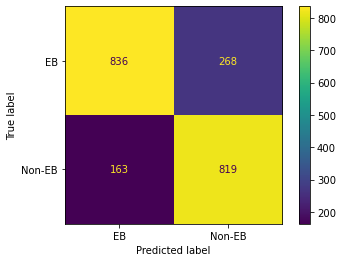

In [203]:
fig, ax = plt.subplots()
svc1_confusion_matrix_plot = plot_confusion_matrix(svc_gridcv_1,X_test,y_test,ax=ax,labels=['EB','Non-EB'])
plt.savefig('sklearn_plots_for_wandb/svc1_gridcv_1_confusion_matrix.png')

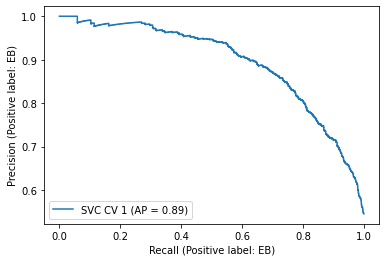

In [204]:
fig, ax = plt.subplots()
svc1_precision_recall_plot = plot_precision_recall_curve(svc_gridcv_1,X_test,y_test,ax=ax,name='SVC CV 1',pos_label='EB')
plt.savefig('sklearn_plots_for_wandb/svc1_gridcv_1_precision_recall.png')

Nice, that went well! Now let me try logging these to W&B.

In [168]:
# I'll need to make a config dictionary to pass into wandb.init so I can organize the runs by hyperparameters. So 
# let me see if I can access these the way I think I can
print(svc_gridcv_1.best_estimator_)
print(svc_gridcv_1.best_estimator_.steps)
print(svc_gridcv_1.best_estimator_.steps[-1])
print(svc_gridcv_1.best_estimator_.steps[-1][-1])
print(svc_gridcv_1.best_estimator_.steps[-1][-1].C)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, random_state=36, tol=0.0001))])
[('standardscaler', StandardScaler()), ('svc', SVC(C=5, random_state=36, tol=0.0001))]
('svc', SVC(C=5, random_state=36, tol=0.0001))
SVC(C=5, random_state=36, tol=0.0001)
5


In [175]:
svc_gridcv_1.best_estimator_.steps[-1][-1].get_params()

{'C': 5,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 36,
 'shrinking': True,
 'tol': 0.0001,
 'verbose': False}

In [176]:
svc_gridcv_1.best_estimator_.steps[-1][-1].get_params()['C']

5

In [183]:
# So I should be able to do something where I pass into the function a list of all the hyperparameters that I'm 
# varying, and I then say, for each in that list, get_params()['each'] and record the result to pass to W&B config
svc_gridcv_1_hyperlist = ['C','kernel','gamma','tol','random_state'] # This should be an attribute of svc_gridcv_1

In [184]:
svc_gridcv_1_config = {} # Will hold C, kernel, gamma, tol, random_state for best run in svc_gridcv_1
for param in svc_gridcv_1_hyperlist:
    svc_gridcv_1_config[param] = svc_gridcv_1.best_estimator_.steps[-1][-1].get_params()[param]
print(svc_gridcv_1_config)

{'C': 5, 'kernel': 'rbf', 'gamma': 'scale', 'tol': 0.0001, 'random_state': 36}


In [205]:
with wandb.init(project='tess',group='svc_gridcv_1',config=svc_gridcv_1_config):
    wandb.log({'accuracy': svc1_accuracy,
               'precision': svc1_precision,
               'recall': svc1_recall,
               'f1_score': svc1_f1,
               'auc': svc1_auc,
               'confusion_matrix': svc1_confusion_matrix,
               'confusion_matrix_plot': wandb.Image('sklearn_plots_for_wandb/svc1_gridcv_1_confusion_matrix.png'),
               'precision_recall_plot': wandb.Image('sklearn_plots_for_wandb/svc1_gridcv_1_precision_recall.png')})

wandb: wandb version 0.11.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


accuracy,0.79338
precision,0.83684
recall,0.75725
f1_score,0.79505
auc,0.87508
_runtime,6
_timestamp,1627863864
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


### Make a Function to Do a sklearn Grid Search and Log the Results to W&B
That was pretty successful. Now I think I should write a function to make it a little more automated. 

In [329]:
# pipeline should be a pre-made pipeline like make_pipeline(StandardScaler(),svm.SVC(random_state=36))
# hypers should be a dictionary like {'svc__C':[0.001,0.009,0.01,0.09,1,5,10,25],...}
# cv_scoring should be a dict like {'accuracy': make_scorer(accuracy_score),...}. It's the dict of all the metrics
# I want sklearn to track for the purpose of evaluating model performance during the cross-validation
# refit is the metric I want GridSearchCV() to use to evaluate which model is the best and is 'accuracy' by 
# default. But I can also write a function that will take in cv_results_ and return the sum of mean accuracy + 
# mean precision + mean recall and specify that function, or I could specify 'auc' to use the area under the ROC
# curve
# Update 8/2/21: X_train, X_test, y_train, and y_test are the train and test data, just like they sound like. I am
# changing the function so that these now need to be passed in as arguments rather than having the function just
# use whatever global variables named X_train, X_test, etc. already exist. So previous calls to this function in
# this notebook might not work, but it can be easily remedied by adding those arguments in the call [end update]
# pos_label is the data label to be used as the "positive" one for the purposes of computing precision, recall, 
# f1, etc. It is "EB" by default but can be changed for the future when I want to use multiple variable types
# labels is all the data labels in the set - used for confusion matrix. Currently it is ['EB','Non-EB'] by default
# but can be changed
# run_name is for purposes of saving the confusion matrix and p-r curve plots - need a proper filename. For
# example, 'svc_gridcv_1'. Also used in the legend for the p-r curve plot and in saving the cv_results_ df
# df_directory is the directory in which I'll store the Pandas dataframes from CV (cv_results_)
def grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train,X_test,y_train,y_test,refit='accuracy',
                       pos_label='EB',labels=['EB','Non-EB'],df_directory='sector_14_gridsearchcv_dfs'):
    grid = GridSearchCV(pipeline,hypers,scoring=cv_scoring,refit=refit,n_jobs=-1,verbose=1,error_score=0)
    grid.fit(X_train,np.ravel(y_train)) # np.ravel flattens the array and makes it play nice with .fit()
    y_pred = grid.predict(X_test) # Predict on the test dataset to evaluate performance of the best model
    grid_results_df = pd.DataFrame(grid.cv_results_) # Get pandas dataframe w/ CV summary (training/validation)
    grid_results_df.to_pickle(df_directory + '/' + run_name + '.zip')
    # Get scores on the test data
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label=pos_label)
    recall = recall_score(y_test,y_pred,pos_label=pos_label)
    f1 = f1_score(y_test,y_pred,pos_label=pos_label)
    # roc_auc_score requires 'y_score', which apparently can be 'estimator.decision_function(X,y)' (according to 
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
    y_score = grid.predict_proba(X_test)[:,1] # Currently only good for binary case (2 classes, not more)
    auc = roc_auc_score(y_test,y_score)
    confusion_matrix_ = confusion_matrix(y_test,y_pred,labels=labels) # Add underscore to avoid assignment error
    print('Accuracy: ' + str(accuracy) + '\nPrecision: ' + str(precision) + '\nRecall: ' + str(recall) + 
          '\nF1-score: ' + str(f1) + '\nAUC (ROC): ' + str(auc))
    fig, ax = plt.subplots()
    confusion_matrix_plot = plot_confusion_matrix(grid,X_test,y_test,ax=ax,labels=labels)
    plt.savefig('sklearn_plots_for_wandb/' + run_name + '_confusion_matrix.png')
    fig, ax = plt.subplots()
    precision_recall_plot = plot_precision_recall_curve(grid,X_test,y_test,ax=ax,name=run_name,pos_label=pos_label)
    plt.savefig('sklearn_plots_for_wandb/' + run_name + '_precision_recall.png')
    # Get list of just the actual hyperparameters (without values) for use in generating W&B config
    grid_hyperlist = list(hypers.keys()) # These still have '[estimator_type]__' in front of them - remove this:
    double_underscore_index = grid_hyperlist[0].find('__') # Search 1st key in hypers
    if double_underscore_index == -1: # Meaning, there's no __ in the string, which would mean I forgot to add it
        raise Exception
    for i, el in enumerate(grid_hyperlist):
        new_el = el[double_underscore_index+2:] # +2 to account for the length of '__' itself
        grid_hyperlist[i] = new_el # Now grid_hyperlist should just have the hyperparams w/o the 'svc__' or similar
    config = {} # Will hold hyperparameters for best run in grid
    for param in grid_hyperlist:
        config[param] = grid.best_estimator_.steps[-1][-1].get_params()[param]
    # Log everything to Weights & Biases
    with wandb.init(project='tess',group=run_name,config=config):
        wandb.log({'accuracy': accuracy,
                   'precision': precision,
                   'recall': recall,
                   'f1_score': f1,
                   'auc': auc,
                   'confusion_matrix': confusion_matrix_,
                   'confusion_matrix_plot': wandb.Image('sklearn_plots_for_wandb/' + run_name + '_confusion_matrix.png'),
                   'precision_recall_plot': wandb.Image('sklearn_plots_for_wandb/' + run_name + '_precision_recall.png')})

### Test Out Function by Redoing RF and KNN Classifiers from Above (Now w/ CV)

Now let me try out redoing the random forest and the k-nearest neighbors classifiers with cross-validation, using the function above.

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Accuracy: 0.7962607861936721
Precision: 0.8236415633937083
Recall: 0.782608695652174
F1-score: 0.8026010218300047
AUC (ROC): 0.8974087930576463


wandb: wandb version 0.11.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


accuracy,0.79626
precision,0.82364
recall,0.78261
f1_score,0.8026
auc,0.89741
_runtime,5
_timestamp,1627927393
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


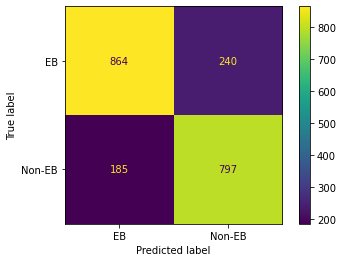

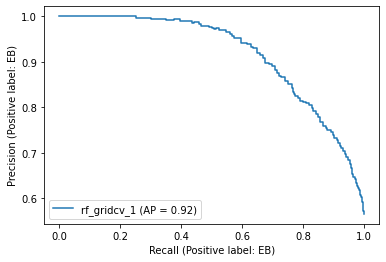

In [239]:
# Random forest
pipeline = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=71))
rfc = 'randomforestclassifier__'
hypers = {rfc + 'n_estimators': [1,10,100,500,1000],
          rfc + 'criterion': ['gini','entropy'],
          rfc + 'max_depth': [3,5,10,50,None],
          rfc + 'min_samples_split': [2,5,10,50],
          rfc + 'max_features': ['sqrt',None]}
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'rf_gridcv_1'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name) # Here refit = 'accuracy' (default)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 0.7785234899328859
Precision: 0.7994402985074627
Recall: 0.7762681159420289
F1-score: 0.7876838235294117
AUC (ROC): 0.8750797876265534


wandb: wandb version 0.11.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


accuracy,0.77852
precision,0.79944
recall,0.77627
f1_score,0.78768
auc,0.87508
_runtime,6
_timestamp,1627927770
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


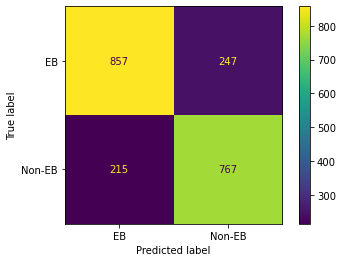

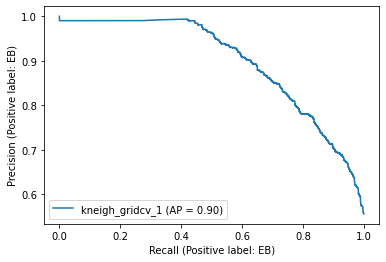

In [242]:
# K neighbors
pipeline = make_pipeline(StandardScaler(),KNeighborsClassifier())
knc = 'kneighborsclassifier__'
hypers = {knc + 'n_neighbors': [1,2,3,5,10,20],
          knc + 'weights': ['uniform','distance'],
          knc + 'metric': ['minkowski','mahalanobis'],
          knc + 'p': [1,2,3]}
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'kneigh_gridcv_1'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name) # Again refit = 'accuracy'

Next thing to do might be to take the cv_results_ dataframes from the three runs above and get a new best run, this time based on the sum of accuracy + recall + precision, or even just AUC. Then record the same metrics for that run to W&B.

### Find the Best Runs Based on Metrics Besides Accuracy and Log Them
(This section was added 8/3, after I already filtered out the long-period EBs and reran the SVC, RF, and KNN on that new dataset.)

In the above 3 runs, I chose the "best" run (the one I ultimately logged to W&B) based on accuracy alone. Here I want to log a couple more runs, this time based on AUC and maybe also on accuracy + precision + recall.

In [343]:
# The three dataframes I'm concerned with are svc_gridcv_1_results_df for the SVC, and then reading in 
# rf_gridcv_1.zip for RF and kneigh_gridcv_1.zip for KNN (these files are pickled)
# Start with the SVC
svc_gridcv_1_results_df['mean_test_auc']

0      0.762100
1      0.762100
2      0.762178
3      0.779782
4      0.779773
         ...   
139    0.862769
140    0.862773
141    0.666686
142    0.666677
143    0.666677
Name: mean_test_auc, Length: 144, dtype: float64

In [344]:
np.argmax(svc_gridcv_1_results_df['mean_test_auc'])

95

In [345]:
svc_gridcv_1_results_df['mean_test_auc'][95]

0.8662278464376267

Now that I know which run performed the best according to this metric, I need a way to actually "get" that estimator (model) so I can use it to predict the test data and then log the metrics to W&B. 

### Changing Data -- Eliminate Long-Period EBs
At this point I want to filter out some data that might be kind of bum, with the goal of improving classifier performance. The primary thing I want to do is get rid of EBs with periods longer than 15 days. Let me see how many of those are currently in my data. This is a slight challenge since the lookup tables themselves don't have period information (since most of the stars in there are not even periodic) and I didn't have the foresight when I made the final_input_df table to put a period column in. So what's the best way to figure out which of my 2172 EBs are long-period? 

The keplerebs_villanova_kmag_10-15.csv file has period info, but of course it doesn't have TIC IDs, only KIC IDs. So it seems like I might need to go through the process again of using Jim's KIC2TIC converter to get the TIC IDs, then once I do that I can look them up in final_input_df to match periods to TIC IDs. 

After doing that I can make a copy of final_input_df and remove all the relevant TIC IDs from it. Depending on how many EBs I end up with after that, I might have to remove some non-EBs at random too to balance it out. And I guess I can do the same thing for the fset dataframe since the rows (I'm pretty sure) correspond one-for-one with those in final_input_df.

In [243]:
# Read in keplerebs_villanova_kmag_10-15.csv - just first 3 columns (KIC ID, period, period_err)
keplerebs_10_15 = pd.read_csv('keplerebs_villanova_kmag_10-15.csv',header=None,
                              names=['KIC_ID','period','period_err'],index_col=False,usecols=[0,1,2],skiprows=6)

In [244]:
keplerebs_10_15 # Period is in days according to keplerebs.villanova.edu > Help

,KIC_ID,period,period_err
0,8912468,0.094838,0.000000e+00
1,8758716,0.107205,0.000000e+00
2,10855535,0.112782,0.000000e+00
3,9472174,0.125765,1.000000e-07
4,9612468,0.133471,1.000000e-07
...,...,...,...
1992,9408440,989.985000,-1.000000e+00
1993,8054233,1058.000000,-1.000000e+00
1994,7672940,1064.270000,-1.000000e+00
1995,11961695,1082.815000,-1.000000e+00


**Edit:** Just realized I shouldn't be using keplerebs_villanova_kmag_10-15.csv - that's the old file that was filtered by Kepler mag when I really need to filter them by TESS mag. Let me instead read in the keplerebs_villanova_complete.csv file. 

In [297]:
keplerebs_complete = pd.read_csv('keplerebs_villanova_complete.csv',header=None,
                              names=['KIC ID','period','period_err'],index_col=False,usecols=[0,1,2],skiprows=8)

In [298]:
keplerebs_complete

,KIC ID,period,period_err
0,3863594,0.053268,0.0
1,10417986,0.073731,0.0
2,8912468,0.094838,0.0
3,8758716,0.107205,0.0
4,10855535,0.112782,0.0
...,...,...,...
2917,9408440,989.985000,-1.0
2918,8054233,1058.000000,-1.0
2919,7672940,1064.270000,-1.0
2920,11961695,1082.815000,-1.0


In [299]:
# Read in KIC2TIC file
kic2tic_path = '~/kic2tic/KIC2TIC.csv'
k2t = pd.read_csv(kic2tic_path,header=None,names=['KIC ID','TIC ID'],index_col=False,
                  dtype={'KIC ID':int,'TIC ID':int},skiprows=1)

In [300]:
# Now the full Villanova Kepler data is loaded in - I need to convert all these KIC IDs to TIC IDs
ticids_kepler = []
not_found_counter = 0 # Will count how many KIC IDs aren't found in the k2t dataframe
for kicid in keplerebs_complete['KIC ID']:
    inds = np.where(k2t['KIC ID'] == kicid)[0]
    if inds.size == 0:
        not_found_counter += 1
        ticids_kepler.append(-1) # Threw this in here so ticids_kepler will correspond 1-to-1 w/ keplerebs_complete
        continue
    elif inds.size > 1:
        print('More than one line present for KIC ID ' + str(kicid))
    ticids_kepler.append(k2t['TIC ID'][inds[0]]) # Add the 1st TIC ID to the list (presumably it will be the only TIC ID)
print('Number not found: ' + str(not_found_counter))

Number not found: 23


Now I have a list (ticids_kepler) of 2922 TIC IDs of EBs (23 are missing though, listed as -1) and the corresponding periods (in days) for those EBs. That means I can put a mask on and take only those TIC IDs with periods < 15 days. Then loop through all those and get the indices they occupy in final_input_df (and fset). There are a few repeated TIC IDs in ticids_kepler, but that shouldn't matter. 

In [308]:
ticids_kepler = np.asarray(ticids_kepler)
short_period_ebs = np.where(keplerebs_complete['period'] < 15)[0]
print(short_period_ebs.size) # Sanity check
final_input_df_short_period_eb_inds = [] # Stores exactly what it says in the name
for ticid in ticids_kepler[short_period_ebs]:
    if ticid == -1:
        continue
    else: # Go through every TIC ID that corresponds to short-period EB and if it's in final_input_df, get index
        # I know that above I was casting the dataframes as np arrays to use np.where, but I just did a test and 
        # it looks like both np.where and indexing with a list works fine on Pandas dataframes. So I'll do this:
        inds = np.where(final_input_df['TIC ID'] == ticid)[0]
        # I can just do .extend here without worrying about whether inds has size 0, 1, or more, because if it's 0,
        # then nothing happens when I extend, if it's 1, then I add it onto the list. It won't be more because 
        # final_input_df['TIC ID'] has no duplicates. Reasons why inds.size could be 0 include that this EB doesn't
        # have TESS magnitude between 10 and 15, or it might be in sector 15 instead of 14
        final_input_df_short_period_eb_inds.extend(inds)
print(len(final_input_df_short_period_eb_inds))

2266
1700


In [313]:
final_input_df_short_period = final_input_df # First just make a copy
fset_short_period = fset # Same

In [314]:
# Demonstration of how to get selected rows from a dataframe with .iloc
final_input_df_short_period.iloc[[4,28,5]]

,filename,RA,dec,TIC ID,sector,camera,CCD,mag,label
4,tesslcs_sector_14_104/tesslcs_tmag_11_12/tessl...,291.003492,38.526853,122684183,14,1,2,11.8381,EB
28,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,300.084735,18.065595,1944420098,14,1,3,12.7744,Non-EB
5,tesslcs_sector_14_104/2_min_cadence_targets/te...,297.757083,41.680453,169820068,14,1,1,11.5768,EB


In [315]:
# Now modify them so they're only the rows corresponding to short periods
# Hold on though! I need to include all the non-EBs too!
# Get the locations of all the non-EBs
non_eb_inds = np.where(final_input_df['label'] == 'Non-EB')[0]
final_input_df_short_period_eb_inds.extend(non_eb_inds) # Now this has all non-EBs, and all short-period EBs
final_input_df_short_period = final_input_df_short_period.iloc[final_input_df_short_period_eb_inds]
fset_short_period = fset_short_period.iloc[final_input_df_short_period_eb_inds]

In [316]:
final_input_df_short_period

,filename,RA,dec,TIC ID,sector,camera,CCD,mag,label
1049,tesslcs_sector_14_104/2_min_cadence_targets/te...,300.115595,45.167923,239276223,14,2,4,11.3448,EB
1801,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,293.851884,44.949421,270700726,14,2,4,12.9554,EB
1996,tesslcs_sector_14_104/2_min_cadence_targets/te...,294.635885,46.066428,271164763,14,2,4,12.4561,EB
2736,tesslcs_sector_14_104/2_min_cadence_targets/te...,299.982135,46.262322,239233211,14,2,4,11.2247,EB
3041,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,293.976538,42.048293,270779991,14,2,4,12.1877,EB
...,...,...,...,...,...,...,...,...,...
4160,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,290.863126,32.616685,394545581,14,1,2,14.4371,Non-EB
4165,tesslcs_sector_14_104/tesslcs_tmag_13_14/tessl...,308.884871,36.592607,63936768,14,1,1,13.9156,Non-EB
4166,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,133.364098,66.203678,356603327,14,4,3,14.2054,Non-EB
4167,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,299.301885,20.839294,263369443,14,1,3,14.4938,Non-EB


In [317]:
fset_short_period

,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,percent_beyond_1_std,period_fast,skew,std,...,freq2_amplitude2,freq3_amplitude1,freq3_amplitude2,freq_model_max_delta_mags,freq_signif_ratio_21,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,p2p_ssqr_diff_over_var
1049,0.003797,0.201667,0.365424,0.532957,0.675069,0.842390,0.376840,7.596789,-0.050773,0.001501,...,0.000215,0.000221,0.000073,5.360478e-13,0.473592,0.343512,6.743412e-07,3.696671e-06,-1.261760e-06,2.697675
1801,0.005930,0.174125,0.287813,0.422294,0.585144,0.772402,0.309127,0.053602,0.159209,0.001447,...,0.000185,0.000300,0.000029,4.891028e-12,0.704948,0.384937,1.328131e-06,2.523882e-05,-9.668272e-06,1.848711
1996,0.067521,0.290196,0.491906,0.661809,0.821002,0.943930,0.468106,0.125763,0.123934,0.041757,...,0.000077,0.001595,0.000391,3.696671e-10,0.405741,0.383410,1.386374e-05,1.580525e-03,-1.501061e-04,1.282513
2736,0.002502,0.173387,0.286012,0.415784,0.576231,0.770106,0.313052,0.066746,0.096606,0.000753,...,0.000004,0.000234,0.000017,5.154973e-12,0.736308,0.650322,4.618373e-07,3.881071e-07,-8.560114e-07,1.690447
3041,0.006257,0.146545,0.263201,0.399122,0.595158,0.801174,0.346418,0.075396,-0.125684,0.002179,...,0.000042,0.000597,0.000372,1.363398e-11,0.910551,0.655825,2.574000e-06,-8.174891e-06,-4.321939e-06,2.101932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,0.336395,0.047634,0.086660,0.135441,0.233650,0.504602,0.133874,0.164381,-0.121631,0.038178,...,0.000069,0.001699,0.000096,9.497088e-12,0.913336,0.893030,4.416620e-04,-4.028340e-05,4.614538e-05,1.348277
4165,0.428319,0.103874,0.190078,0.271721,0.382987,0.614893,0.091278,0.169664,1.287088,0.037390,...,0.000115,0.001822,0.000093,4.311574e-12,0.997028,1.002642,4.360228e-04,-1.182042e-05,-2.623576e-05,1.505018
4166,0.062264,0.137213,0.278063,0.410047,0.563084,0.790287,0.305583,1.633915,0.115393,0.018315,...,0.004315,0.006072,0.001344,1.252161e-11,0.930394,0.883934,2.884051e-04,-1.287706e-04,-3.284953e-05,0.428175
4167,0.370781,0.113816,0.214648,0.341702,0.491092,0.704121,0.044625,8.080899,-7.670332,0.067641,...,0.000124,0.001327,0.000104,3.042112e-11,0.809644,0.720744,4.563702e-04,-7.369193e-05,-4.589846e-05,0.311539


Cool - now I have new "short-period" dataframes that I can use to generate a new set of training and test data. Getting rid of the long-period EBs left me with 1700 short-period EBs and 2000 non-EBs. I'll use these to train a new model. Not sure if 1700 vs. 2000 is too imbalanced, but I'm rolling with it for now. 

In [318]:
# Let me shuffle the dataframes just in case it's a problem to use them as-is - obviously need to make sure I 
# shuffle them the same way
final_input_df_short_period = final_input_df_short_period.sample(frac=1,random_state=7)
fset_short_period = fset_short_period.sample(frac=1,random_state=7)

Did they get shuffled the same way? Let's look at the indexes (in bold on the left):

In [319]:
final_input_df_short_period

,filename,RA,dec,TIC ID,sector,camera,CCD,mag,label
1467,tesslcs_sector_14_104/tesslcs_tmag_11_12/tessl...,297.228017,36.674300,169278168,14,1,1,11.7079,Non-EB
3086,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,293.016533,38.318439,137976040,14,1,2,14.2171,EB
1440,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,301.236259,50.092872,364827226,14,2,4,14.5887,Non-EB
2575,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,287.571169,42.813914,158552426,14,2,3,12.3237,EB
3223,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,291.375437,42.811334,159717574,14,2,3,12.5916,EB
...,...,...,...,...,...,...,...,...,...
2927,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,298.542486,41.953200,274118380,14,2,4,12.2254,EB
1792,tesslcs_sector_14_104/tesslcs_tmag_14_15/tessl...,291.246503,30.418857,394688337,14,1,2,14.0961,Non-EB
3087,tesslcs_sector_14_104/tesslcs_tmag_12_13/tessl...,284.320144,42.539014,164674914,14,2,3,12.6504,EB
3268,tesslcs_sector_14_104/2_min_cadence_targets/te...,282.301251,46.516198,123447592,14,2,3,11.9966,EB


In [320]:
fset_short_period

,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,percent_beyond_1_std,period_fast,skew,std,...,freq2_amplitude2,freq3_amplitude1,freq3_amplitude2,freq_model_max_delta_mags,freq_signif_ratio_21,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,p2p_ssqr_diff_over_var
1467,0.154579,0.078303,0.134552,0.205856,0.321605,0.522058,0.132860,3.470431,1.386801,0.014679,...,0.000082,0.000972,0.000016,4.992517e-12,0.809732,0.575230,0.000078,0.000197,-3.830298e-07,1.504063
3086,0.082807,0.151328,0.276182,0.381624,0.505352,0.663153,0.230223,7.321799,-3.312237,0.015949,...,0.000389,0.001859,0.000094,9.408151e-03,0.331369,0.313455,0.000090,-0.001246,2.770090e-05,0.492056
1440,0.022063,0.121574,0.250242,0.381035,0.545326,0.748779,0.231600,8.068466,-0.270451,0.003538,...,0.000174,0.001093,0.000148,3.136950e-03,0.879913,0.828942,0.000010,-0.000325,3.141617e-05,0.836446
2575,0.004472,0.128521,0.243744,0.352045,0.512170,0.743770,0.282630,4.728128,-0.493927,0.001437,...,0.000306,0.000516,0.000038,5.350366e-12,0.916323,0.779464,0.000002,-0.000026,1.395361e-05,1.015021
3223,0.107305,0.174874,0.312522,0.450732,0.605621,0.823299,0.275761,0.566865,0.868982,0.050456,...,0.000490,0.006693,0.000127,4.082810e-09,0.639288,0.623234,0.000112,0.001385,-1.059834e-04,0.290676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,0.055079,0.124925,0.219769,0.315635,0.407809,0.522239,0.135427,5.354199,-1.655723,0.011566,...,0.001823,0.004487,0.002242,9.568197e-11,1.008688,1.077622,0.000114,-0.000175,-4.727427e-05,0.132643
1792,0.025177,0.136758,0.234420,0.338790,0.484024,0.677253,0.314402,6.857352,-0.274994,0.007626,...,0.000337,0.001539,0.000138,2.906341e-11,0.597192,0.581327,0.000040,-0.000063,4.052833e-05,1.022721
3087,0.025199,0.271124,0.472126,0.617073,0.740011,0.885386,0.436703,0.320659,-0.069600,0.012640,...,0.000094,0.000627,0.000153,7.620473e-03,0.503440,0.278036,0.000006,-0.000120,-1.140139e-05,0.298560
3268,0.009573,0.152393,0.272698,0.409663,0.553468,0.765924,0.220805,6.892529,1.567429,0.001206,...,0.000005,0.000136,0.000009,2.044118e-13,0.388493,0.392358,0.000001,0.000040,-1.334771e-06,1.287888


Yep, they did get shuffled the same way! Let me save them both to files quickly.

In [321]:
final_input_df_short_period.to_pickle('sector_14_final_input_df_short_period_8-2-21.zip')
fset_short_period.to_pickle('sector_14_fset_short_period_8-2-21.zip')

That's great. Now I have these dataframes with the long-period EBs removed and I'm good to get train/test data and start training models with them. 
### Training SVC/RF/KNeighbors w/ Long-Period EBs Removed

In [331]:
# Better way of splitting than I used at the start of this notebook; do it all in one line
X_train_short_period, X_test_short_period, y_train_short_period, y_test_short_period = train_test_split(
    fset_short_period,final_input_df_short_period['label'],train_size=0.5,random_state=20)

In [325]:
# Check and make sure there's a reasonable balance of EBs to non-EBs in each
np.where(y_test == 'EB')[0].size

857

That's a pretty good balance - 857 EBs in the test data, and the other 843 in the training data. 

Now let's train some models!
#### SVC

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Accuracy: 0.8237837837837838
Precision: 0.919431279620853
Recall: 0.6791131855309218
F1-score: 0.7812080536912751
AUC (ROC): 0.8946940132855308


wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


accuracy,0.82378
precision,0.91943
recall,0.67911
f1_score,0.78121
auc,0.89469
_runtime,6
_timestamp,1627965424
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


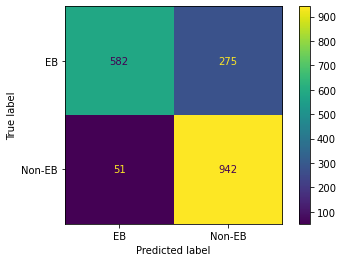

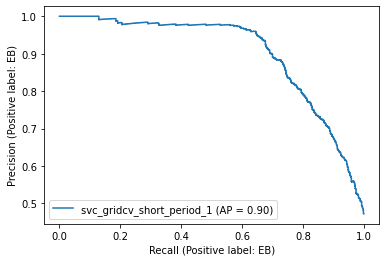

In [336]:
# SVC
pipeline = make_pipeline(StandardScaler(),svm.SVC(probability=True,random_state=47)) # prob=True for auc in func. 
hypers = {'svc__C':[0.001,0.009,0.01,0.09,1,5,10,25],
          'svc__kernel':['poly','rbf','sigmoid'],
          'svc__gamma':['scale','auto'],
          'svc__tol':[1e-4,1e-3,1e-2]}
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'svc_gridcv_short_period_1'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train_short_period,X_test_short_period,
                   y_train_short_period,y_test_short_period) # Here refit = 'accuracy' (default)

#### Random Forest

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Accuracy: 0.8362162162162162
Precision: 0.9097633136094675
Recall: 0.7176196032672112
F1-score: 0.802348336594912
AUC (ROC): 0.9097286607183774


wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


accuracy,0.83622
precision,0.90976
recall,0.71762
f1_score,0.80235
auc,0.90973
_runtime,6
_timestamp,1627972903
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


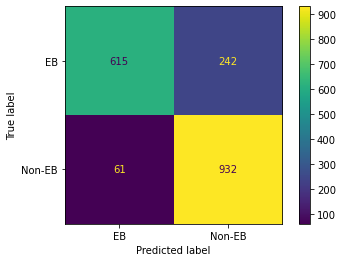

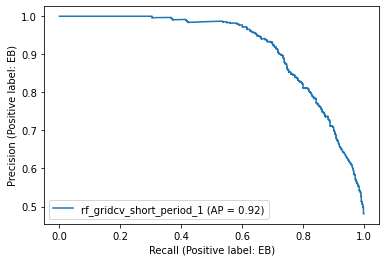

In [337]:
# Random forest
pipeline = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=103))
rfc = 'randomforestclassifier__' # Cut down on training time by eliminating some hyperparameters
hypers = {rfc + 'n_estimators': [100,500,1000], # Removed 1 and 10 from this list since they underperformed
          rfc + 'criterion': ['gini','entropy'],
          rfc + 'max_depth': [3,5,10,50,None],
          rfc + 'min_samples_split': [2,5,10,50],
          rfc + 'max_features': ['sqrt',None]}
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'rf_gridcv_short_period_1'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train_short_period,X_test_short_period,
                   y_train_short_period,y_test_short_period) # Here refit = 'accuracy' (default)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 0.8297297297297297
Precision: 0.8838526912181303
Recall: 0.7281213535589265
F1-score: 0.7984644913627639
AUC (ROC): 0.8945124623825353


wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


accuracy,0.82973
precision,0.88385
recall,0.72812
f1_score,0.79846
auc,0.89451
_runtime,6
_timestamp,1627973392
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


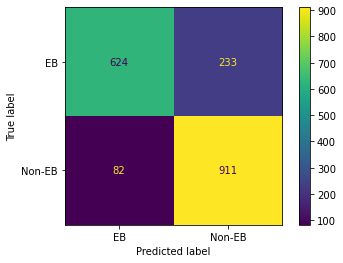

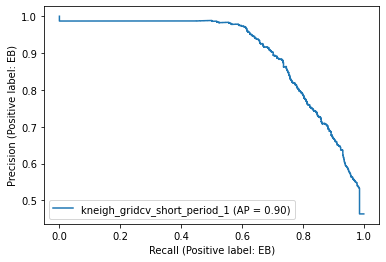

In [338]:
# K neighbors
pipeline = make_pipeline(StandardScaler(),KNeighborsClassifier())
knc = 'kneighborsclassifier__'
hypers = {knc + 'n_neighbors': [1,2,3,5,10,20],
          knc + 'weights': ['uniform','distance'],
          knc + 'metric': ['minkowski','mahalanobis'],
          knc + 'p': [1,2,3]}
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'kneigh_gridcv_short_period_1'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train_short_period,X_test_short_period,
                  y_train_short_period,y_test_short_period) # Again refit = 'accuracy'